In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import functions
import glob as glob
import cartopy.crs as ccrs
import matplotlib as mpl

In [2]:
fbkdir = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/feedbacks/'
tempdir = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/feedback_input/'

In [3]:
cldtype = 'ALL'
experiments = ['abrupt-0_5xCO2', 'abrupt-2xCO2', 'abrupt-4xCO2']
ds_list = []
dT_list = []
dT_annavg_list = []

interval=30
if interval == 30:
    tslicelist = [slice('1920-01-01', '1949-12-31'), slice('1950-01-01', '1979-12-31'),
                slice('1980-01-01', '2009-12-31'), slice('2010-01-01', '2039-12-31'),
                slice('2040-01-01', '2069-12-31')]
elif interval == 15:
    tslicelist = [slice('1920-01-01', '1934-12-31'), slice('1935-01-01', '1949-12-31'),
                slice('1950-01-01', '1964-12-31'), slice('1965-01-01', '1979-12-31'),
                slice('1980-01-01', '1994-12-31'), slice('1995-01-01', '2009-12-31'),
                slice('2010-01-01', '2024-12-31'), slice('2025-01-01', '2039-12-31'),
                slice('2040-01-01', '2054-12-31'), slice('2055-01-01', '2069-12-31')]
elif interval == 10:
    tslicelist = [slice('1920-01', '1929-12'), slice('1930-01-01', '1939-12-31'),
                slice('1940-01-01', '1949-12-31'), slice('1950-01-01', '1959-12-31'),
                slice('1960-01-01', '1969-12-31'), slice('1970-01-01', '1979-12-31'),
                slice('1980-01-01', '1989-12-31'), slice('1990-01-01', '1999-12-31'),
                slice('2000-01-01', '2009-12-31'), slice('2010-01-01', '2019-12-31'),
                slice('2020-01-01', '2029-12-31'), slice('2030-01-01', '2039-12-31'),
                slice('2040-01-01', '2049-12-31'), slice('2050-01-01', '2059-12-31'),
                slice('2060-01-01', '2069-12-31')]
N = int(150/interval)

pi_temp = xr.open_dataset(tempdir+'tas_piClim_final30years.nc')
pi_temp = pi_temp.groupby('time.month').mean('time')
pi_temp = pi_temp.rename({'month':'time'})
pi_temp_annavg = pi_temp.mean('time')

for exp in experiments:

    fbk_files = glob.glob(fbkdir+'interval'+str(interval)+'/'+cldtype+'_'+exp+'_*')
    fbk_files.sort()
    fbk_ds = xr.open_mfdataset(fbk_files, combine='nested', concat_dim='period')
    ds_list.append(fbk_ds)

    temp_ds = xr.open_dataset(tempdir+'tas_'+exp+'_1920-01-01_2069-12-31.nc')

    temp_annavg = temp_ds.groupby('time.year').mean('time')
    temp_annavg['tas'] = temp_annavg['tas'] - pi_temp_annavg['tas']
    dT_annavg_list.append(temp_annavg)
    
    dT = []
    for tslice in tslicelist:
        temp_slice = temp_ds.sel(time=tslice)
        temp_slice = temp_slice.groupby('time.month').mean('time')
        temp_slice = temp_slice.rename({'month':'time'})
        temp_slice['tas'] = temp_slice['tas'] - pi_temp['tas']
        dT.append(temp_slice)

    dT = xr.concat(dT, dim='period')
    dT_list.append(dT)


ds = xr.concat(ds_list, dim='co2_conc')
ds = ds.assign_coords({'period':np.arange(N)*interval})
ds = ds.assign_coords({'co2_conc':['0.5xCO2', '2xCO2', '4xCO2']})

ds_dT = xr.concat(dT_list, dim='co2_conc')
ds_dT = ds_dT.assign_coords({'period':np.arange(N)*interval})
ds_dT = ds_dT.assign_coords({'co2_conc':['0.5xCO2', '2xCO2', '4xCO2']})

ds_dT_annavg = xr.concat(dT_annavg_list, dim='co2_conc')

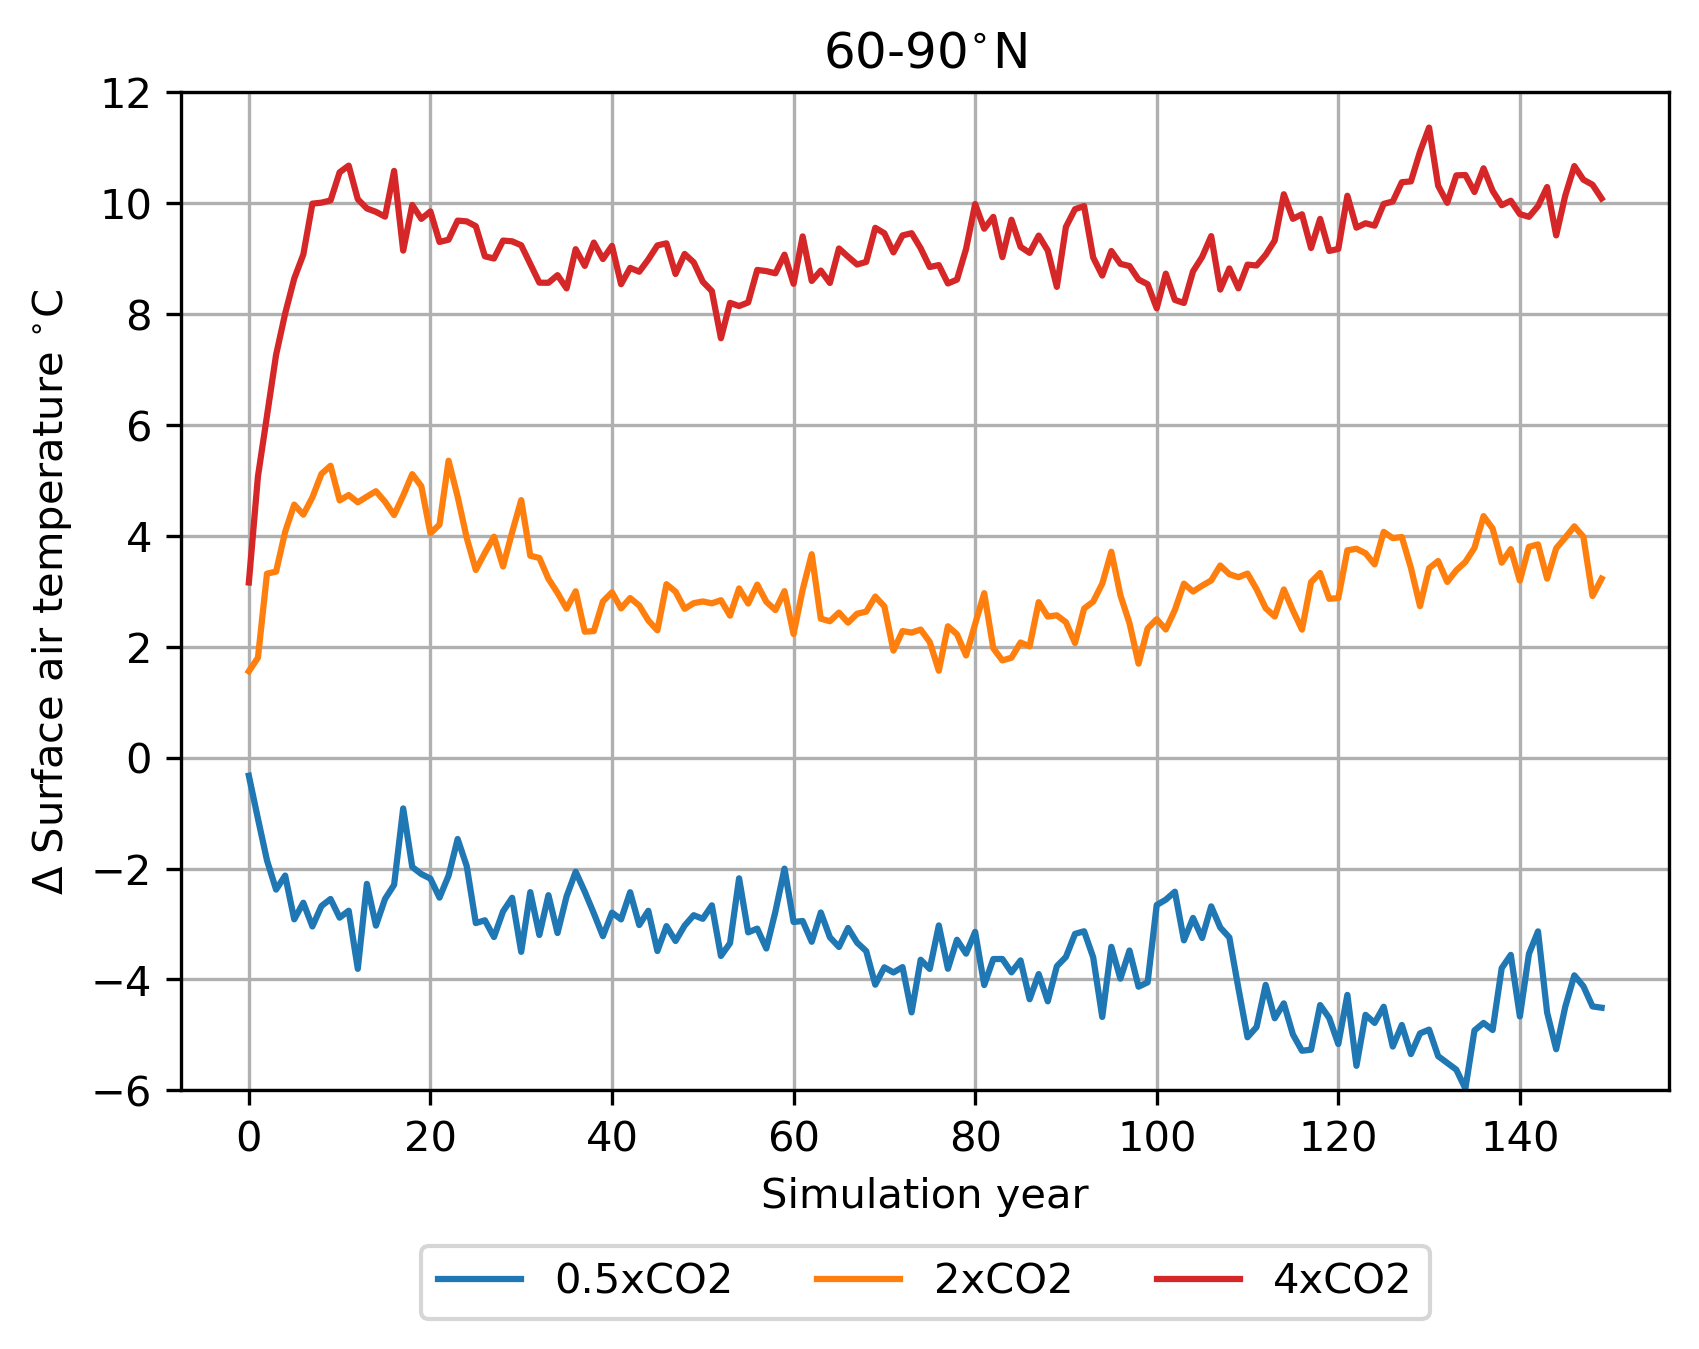

In [6]:
ds_temp_annavg = functions.computeWeightedMean(ds_dT_annavg.sel(lat=slice(60,90)))

plt.figure(dpi=300)
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=0), label='0.5xCO2', color='tab:blue')
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=1), label='2xCO2', color='tab:orange')
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=2), label='4xCO2', color='tab:red')
plt.xlabel('Simulation year')
plt.legend(loc='best')
plt.title('60-90$^{\circ}$N')
plt.ylabel('$\Delta$ Surface air temperature $^{\circ}$C')
plt.ylim([-6, 12])
plt.grid()
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0 + box.height * 0.1,
                box.width, box.height * 0.9])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)

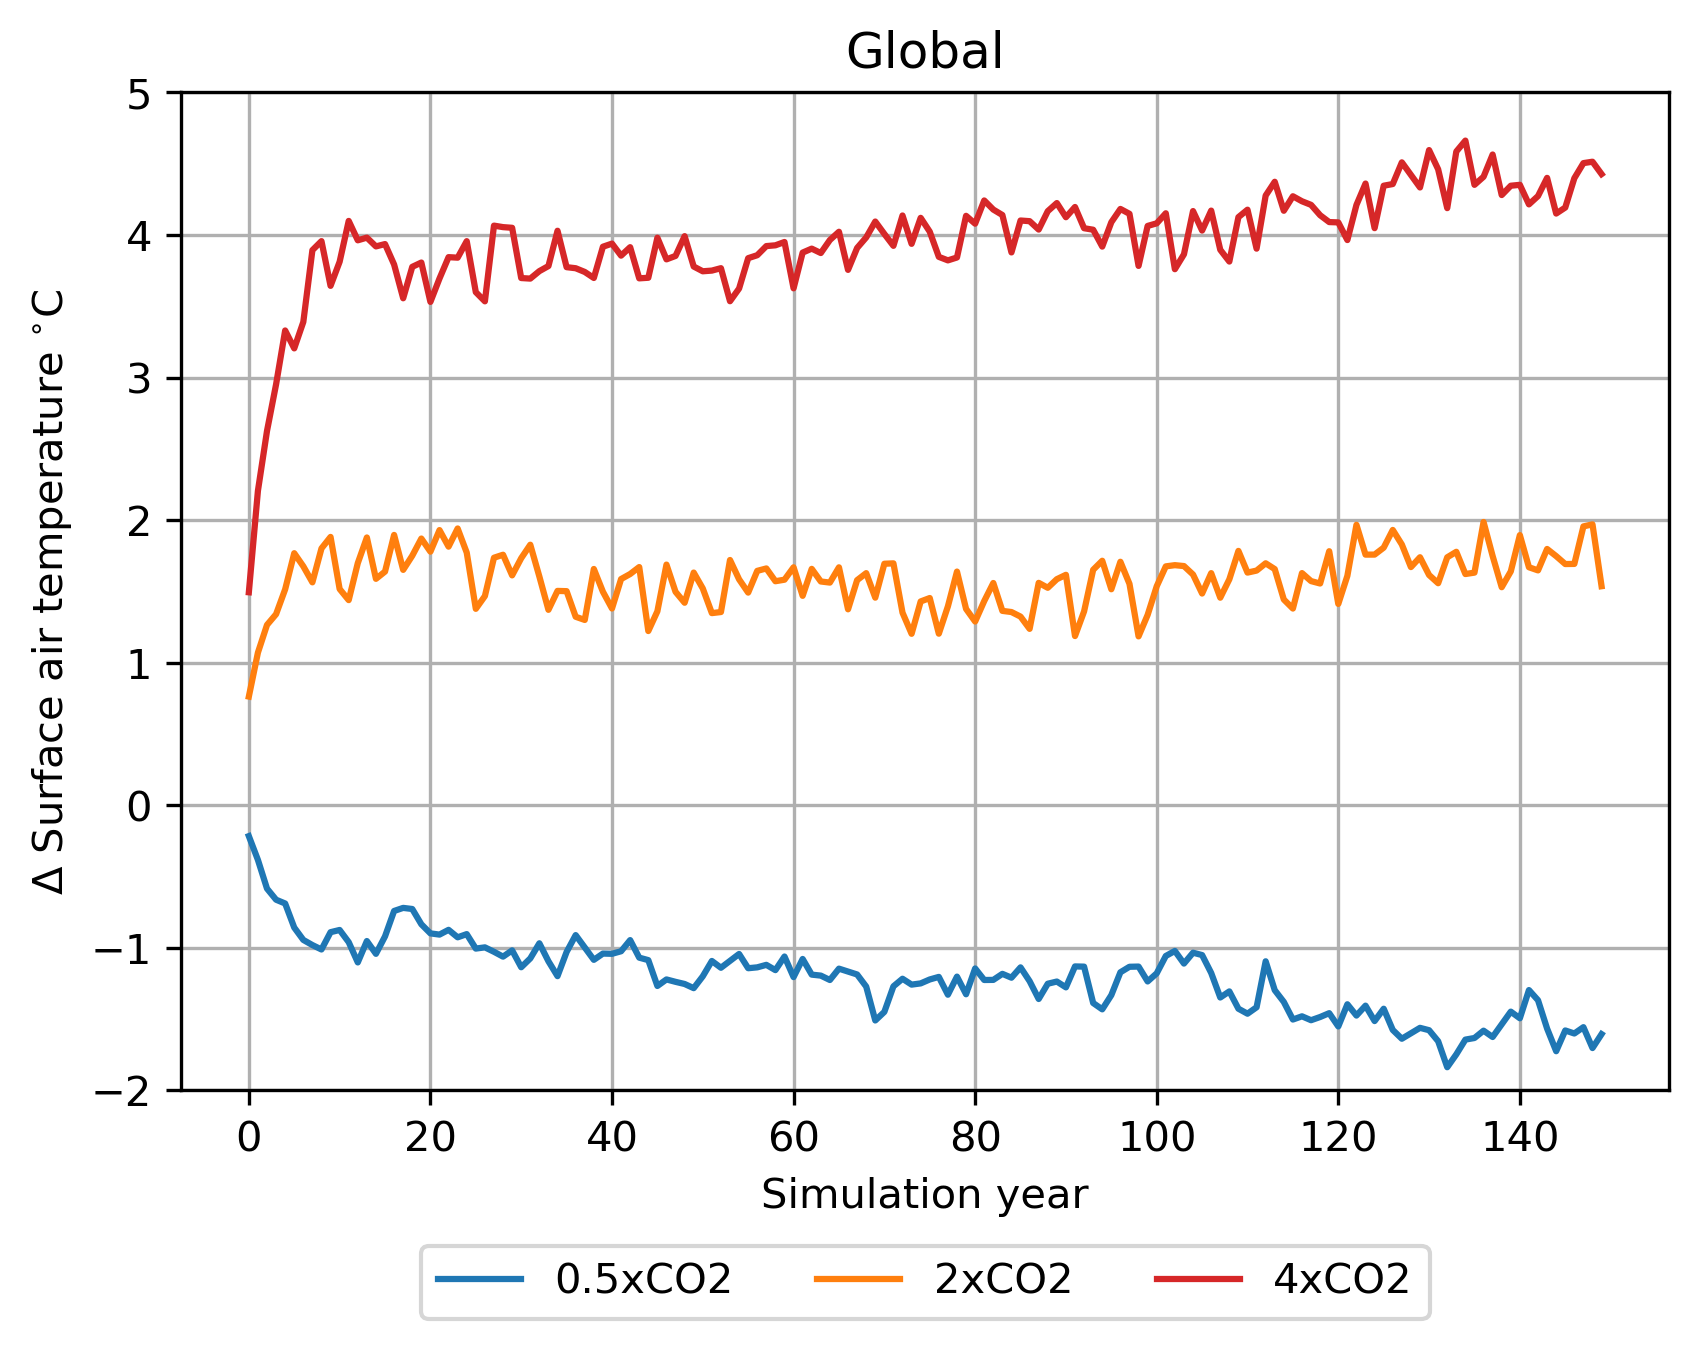

In [6]:
ds_temp_annavg = functions.computeWeightedMean(ds_dT_annavg.sel(lat=slice(-90,90)))

plt.figure(dpi=300)
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=0), label='0.5xCO2', color='tab:blue')
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=1), label='2xCO2', color='tab:orange')
plt.plot(np.arange(150), ds_temp_annavg['tas'].isel(co2_conc=2), label='4xCO2', color='tab:red')
plt.xlabel('Simulation year')
plt.legend(loc='best')
plt.title('Global')
plt.ylabel('$\Delta$ Surface air temperature $^{\circ}$C')
plt.ylim([-2, 5])
plt.grid()
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0 + box.height * 0.1,
                box.width, box.height * 0.9])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)

### Plot cloud feedbacks as a function of time

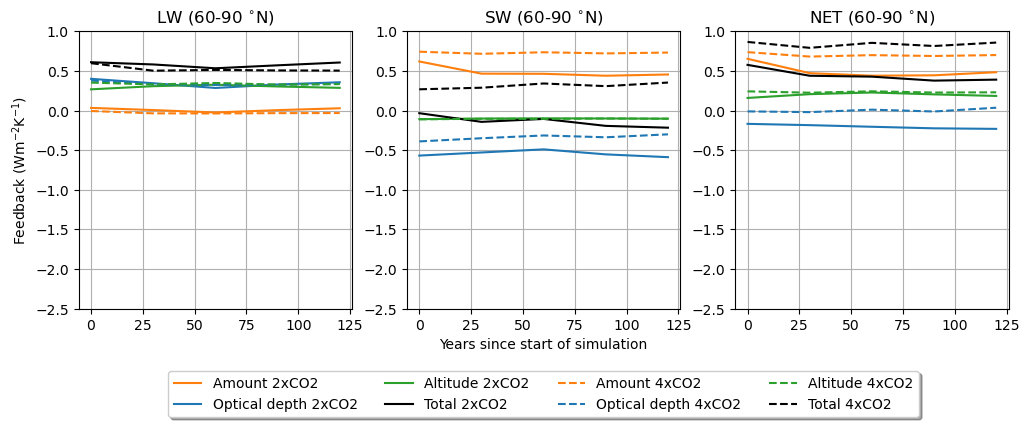

In [39]:
components = ['LW', 'SW', 'NET']
variables = ['amt', 'tau', 'alt', 'err']
variables = ['amt', 'tau', 'alt']
var_labels = ['Amount', 'Optical depth', 'Altitude']
var_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
var_colors = ['tab:orange', 'tab:blue', 'tab:green',]
exp_linestyles = ['-', '--', '-.']

Arctic_limit = 60
ds_Arctic = functions.computeWeightedMean(ds.sel(lat=slice(Arctic_limit,90))).mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit,90))).mean('time')

fig, axs = plt.subplots(1,3, figsize=(12, 4))
for i, co2_conc in enumerate(['2xCO2', '4xCO2']):
    for j in range(len(components)):
        comp = components[j]
        for var, color, label in zip(variables, var_colors, var_labels):
            axs[j].plot(ds_Arctic.period, ds_Arctic[comp+'cld_'+var].sel(co2_conc=co2_conc), color=color, label=label+' '+co2_conc, linestyle=exp_linestyles[i])
        axs[j].plot(ds_Arctic.period, ds_Arctic[comp+'cld_tot'].sel(co2_conc=co2_conc), color='black', label='Total '+co2_conc, linestyle=exp_linestyles[i])

for i in range(len(axs)):
    axs[i].set_title(components[i]+' ('+str(Arctic_limit)+'-90 $^{\circ}$N)')
    axs[i].set_ylim([-2.5, 1])
    axs[i].grid()

    # Shrink bokx size to make room for legend
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

axs[0].set_ylabel('Feedback (Wm$^{-2}$K$^{-1}$)')
axs[1].set_xlabel('Years since start of simulation')
# Put a legend below middle axis
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)


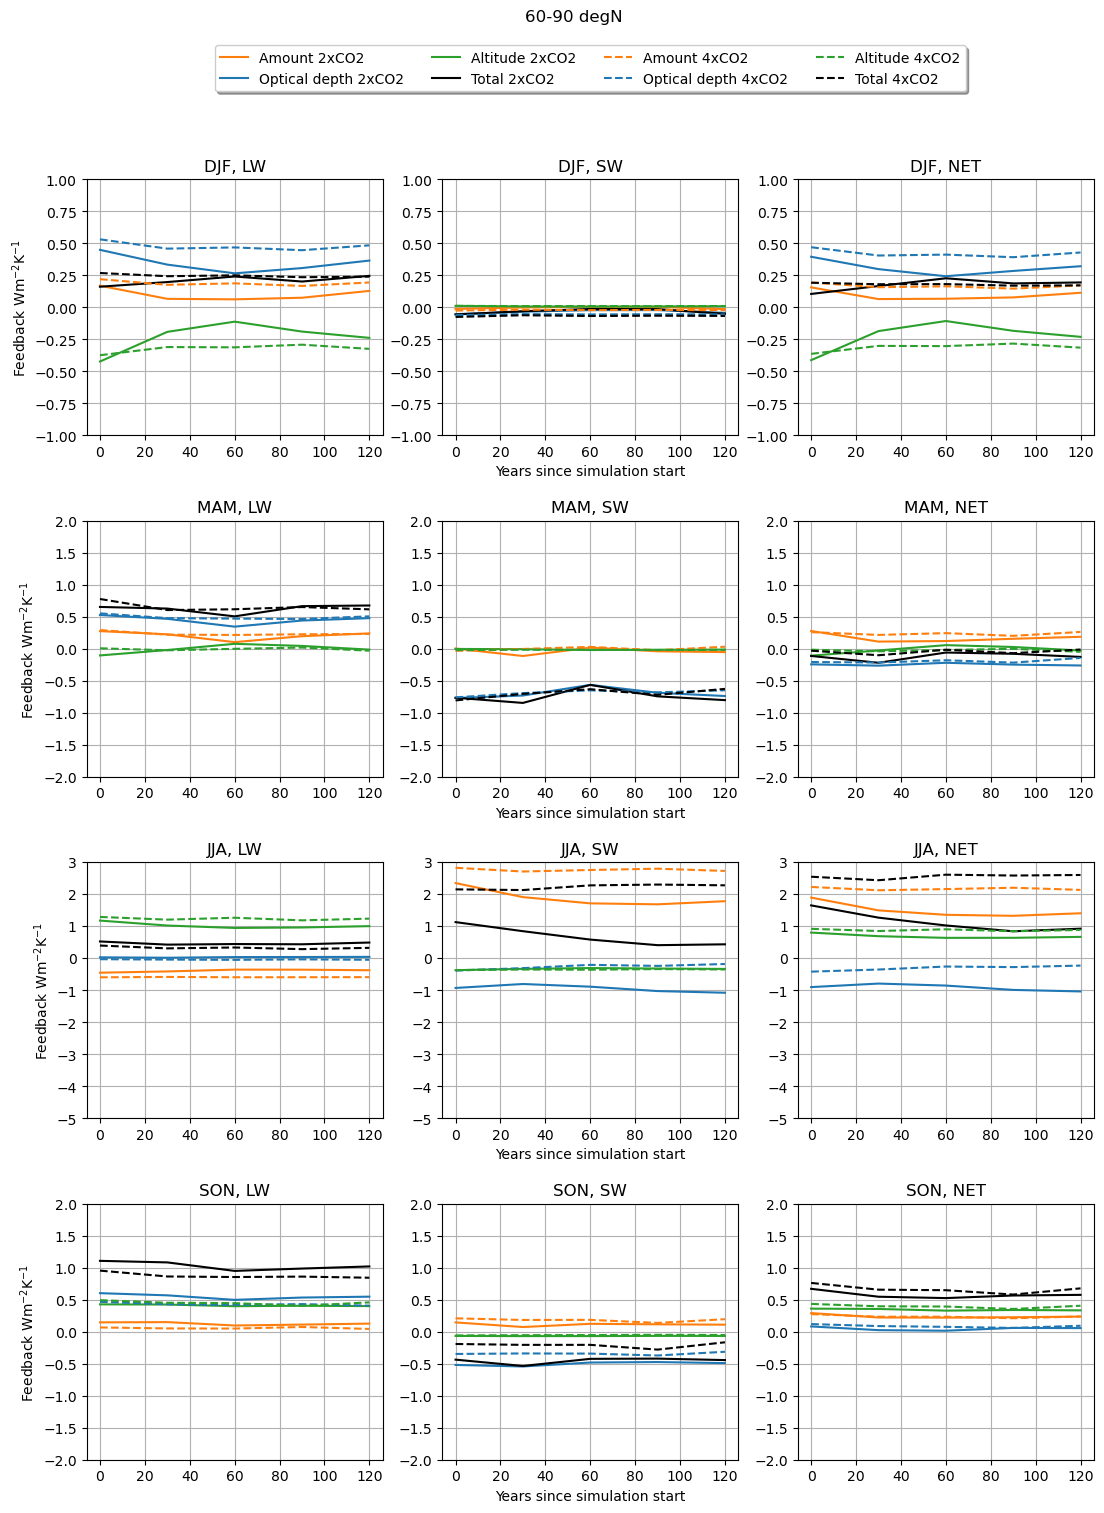

In [44]:
components = ['LW', 'SW', 'NET']
variables = ['amt', 'tau', 'alt', 'err']
variables = ['amt', 'tau', 'alt']
var_labels = ['Amount', 'Optical depth', 'Altitude']
var_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
var_colors = ['tab:orange', 'tab:blue', 'tab:green',]
exp_linestyles = ['-', '--', '-.']
seasons = ['DJF', 'MAM', 'JJA', 'SON']

Arctic_limit = 60
ds_Arctic = functions.computeWeightedMean(ds.sel(lat=slice(Arctic_limit,90))).groupby('time.season').mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit,90)))

fig, axs = plt.subplots(4,3, figsize=(13, 17))
for k in range(len(seasons)):
    ds_dT_Arctic_s = functions.computeSeasonalMean(ds_dT_Arctic, season=seasons[k])
    for i, co2_conc in enumerate(['2xCO2', '4xCO2']):
        for j in range(len(components)):
            comp = components[j]
            for var, color, label in zip(variables, var_colors, var_labels):
                axs[k, j].plot(ds_Arctic.period, ds_Arctic[comp+'cld_'+var].sel(co2_conc=co2_conc, season=seasons[k]), color=color, label=label+' '+co2_conc, linestyle=exp_linestyles[i])
            axs[k, j].plot(ds_Arctic.period, ds_Arctic[comp+'cld_tot'].sel(co2_conc=co2_conc, season=seasons[k]), color='black', label='Total'+' '+co2_conc, linestyle=exp_linestyles[i])
fig.suptitle(str(Arctic_limit)+'-90 degN')

for k in range(len(seasons)):
    axs[k, 0].set_ylabel('Feedback Wm$^{-2}$K$^{-1}$')
    axs[k, 1].set_xlabel('Years since simulation start')
    
    for i in range(len(ds_Arctic.co2_conc)):
        axs[k, i].set_title(seasons[k]+', '+components[i])
        if k == 0:
            axs[k, i].set_ylim([-1, 1])
        elif k == 2:
            axs[k, i].set_ylim([-5, 3])
        else:
            axs[k, i].set_ylim([-2, 2])

        axs[k, i].grid()

        # Shrink box size to make room for legend
        box = axs[k, i].get_position()
        axs[k, i].set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])
    
# Put a legend below middle axis
axs[0, 0].legend(loc='upper center', bbox_to_anchor=(1.7, 1.55),
          fancybox=True, shadow=True, ncol=4)

### Plot feedbacks as a function of temperature

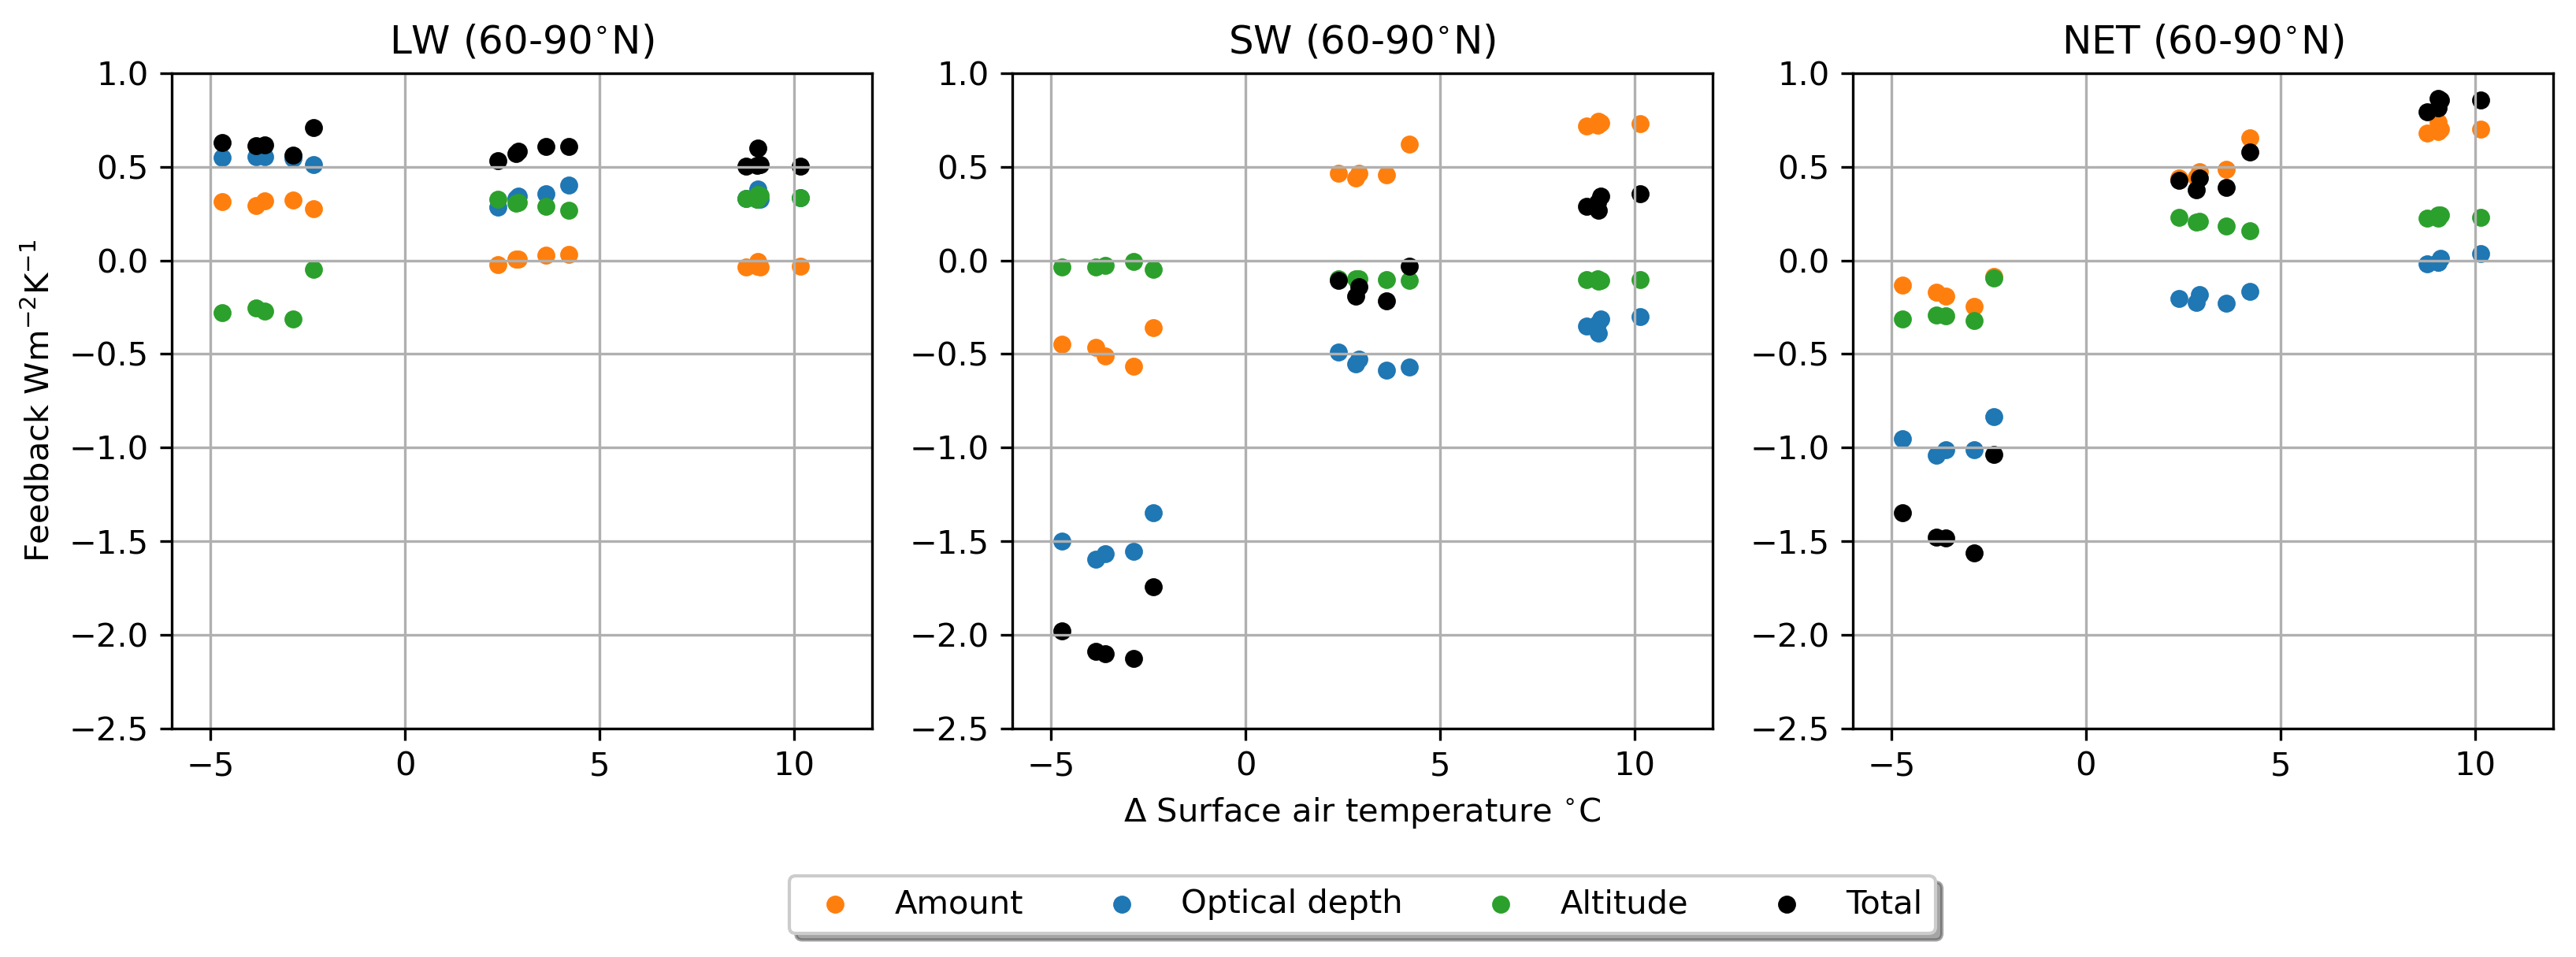

In [5]:
components = ['LW', 'SW', 'NET']
variables = ['amt', 'tau', 'alt', 'err']
variables = ['amt', 'tau', 'alt']
var_labels = ['Amount', 'Optical depth', 'Altitude']
var_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
var_colors = ['tab:orange', 'tab:blue', 'tab:green',]
exp_linestyles = ['-', '--', '-.']

Arctic_limit = 60
ds_Arctic = functions.computeWeightedMean(ds.sel(lat=slice(Arctic_limit,90))).mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit,90))).mean('time')

fig, axs = plt.subplots(1,3, figsize=(13, 4), dpi=300)
for i in range(len(ds_Arctic.co2_conc)):
    for j in range(len(components)):
        comp = components[j]
        for var, color, label in zip(variables, var_colors, var_labels):
            if i == 0: # add label
                axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_'+var].isel(co2_conc=i), color=color, label=label, linestyle='-', s=20)
            else:
                axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_'+var].isel(co2_conc=i), color=color, linestyle='-', s=20)
        if i == 0: # add label
            axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_tot'].isel(co2_conc=i), color='black', label='Total', linestyle='-', s=20)
        else:
            axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_tot'].isel(co2_conc=i), color='black', linestyle='-', s=20)

for i in range(len(axs)):
    axs[i].set_title(components[i]+' ('+str(Arctic_limit)+'-90$^{\circ}$N)')
    axs[i].set_ylim([-2.5, 1])
    axs[i].set_xlim([-6, 12])
    axs[i].grid()

    # Shrink bokx size to make room for legend
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

axs[0].set_ylabel('Feedback Wm$^{-2}$K$^{-1}$')
axs[1].set_xlabel('$\Delta$ Surface air temperature $^{\circ}$C')
# Put a legend below middle axis
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)


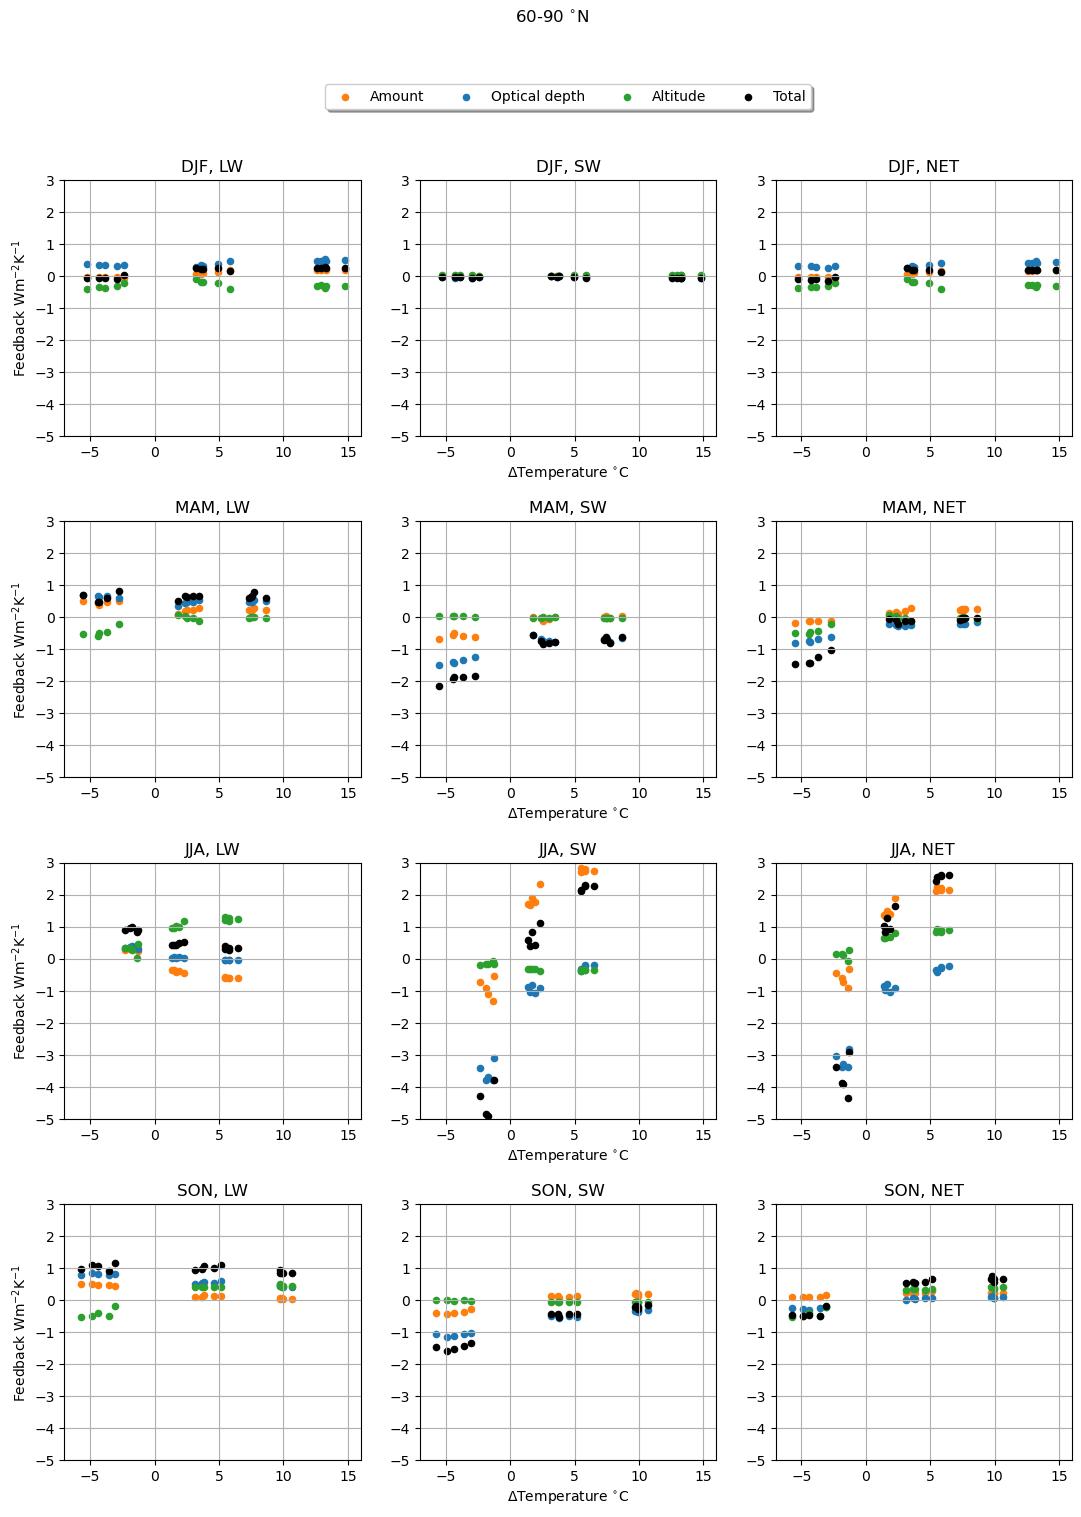

In [47]:
components = ['LW', 'SW', 'NET']
#variables = ['amt', 'tau', 'alt', 'err']
variables = ['amt', 'tau', 'alt']
var_labels = ['Amount', 'Optical depth', 'Altitude']
#var_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
var_colors = ['tab:orange', 'tab:blue', 'tab:green']
seasons = ['DJF', 'MAM', 'JJA', 'SON']

Arctic_limit = 60
ds_Arctic = functions.computeWeightedMean(ds.sel(lat=slice(Arctic_limit, 90))).groupby('time.season').mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit, 90)))

fig, axs = plt.subplots(4,3, figsize=(13, 17))
for k in range(len(seasons)):
    ds_dT_Arctic_s = functions.computeSeasonalMean(ds_dT_Arctic, season=seasons[k])
    for co2_conc in ds_Arctic.co2_conc.values:
        for j in range(len(components)):
            comp = components[j]
            for var, color, label in zip(variables, var_colors, var_labels):
                if co2_conc == '0.5xCO2' and k==0: # add label
                    axs[k, j].scatter(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_'+var].sel(co2_conc=co2_conc, season=seasons[k]), color=color, label=label, s=20)
                else:
                    axs[k, j].scatter(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_'+var].sel(co2_conc=co2_conc, season=seasons[k]), color=color, s=20)
            if co2_conc == '0.5xCO2' and k==0: # add label
                axs[k, j].scatter(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_tot'].sel(co2_conc=co2_conc, season=seasons[k]), color='black', label='Total', s=20)
            else:
                axs[k, j].scatter(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_tot'].sel(co2_conc=co2_conc, season=seasons[k]), color='black', s=20)

fig.suptitle(str(Arctic_limit)+'-90 $^{\circ}$N')

for k in range(len(seasons)):
    axs[k, 0].set_ylabel('Feedback Wm$^{-2}$K$^{-1}$')
    axs[k, 1].set_xlabel('$\Delta$Temperature $^{\circ}$C')
    
    for i in range(len(components)):
        axs[k, i].set_title(seasons[k]+', '+components[i])
        axs[k, i].set_ylim([-5, 3])
        axs[k, i].set_xlim([-7,16])
        axs[k, i].grid()

        # Shrink box size to make room for legend
        box = axs[k, i].get_position()
        axs[k, i].set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])
    
# Put a legend below middle axis
axs[0, 0].legend(loc='upper center', bbox_to_anchor=(1.7, 1.4),
          fancybox=True, shadow=True, ncol=5)

## Plot feedbacks as a function of temperature over land

In [12]:
datadir = '/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/'
landfrac = xr.open_dataarray(datadir+'LANDFRAC_piClim.nc')
landmask = landfrac.isel(time=0)
oceanmask = 1-landmask

# Interpolate to 
landmask_CRK = landmask.interp_like(ds.isel(time=0,period=0,co2_conc=0))
landmask_CRK = landmask_CRK.where(landmask_CRK>=0)
landmask_CRK = landmask_CRK.fillna(0)

oceanmask_CRK = 1-landmask_CRK

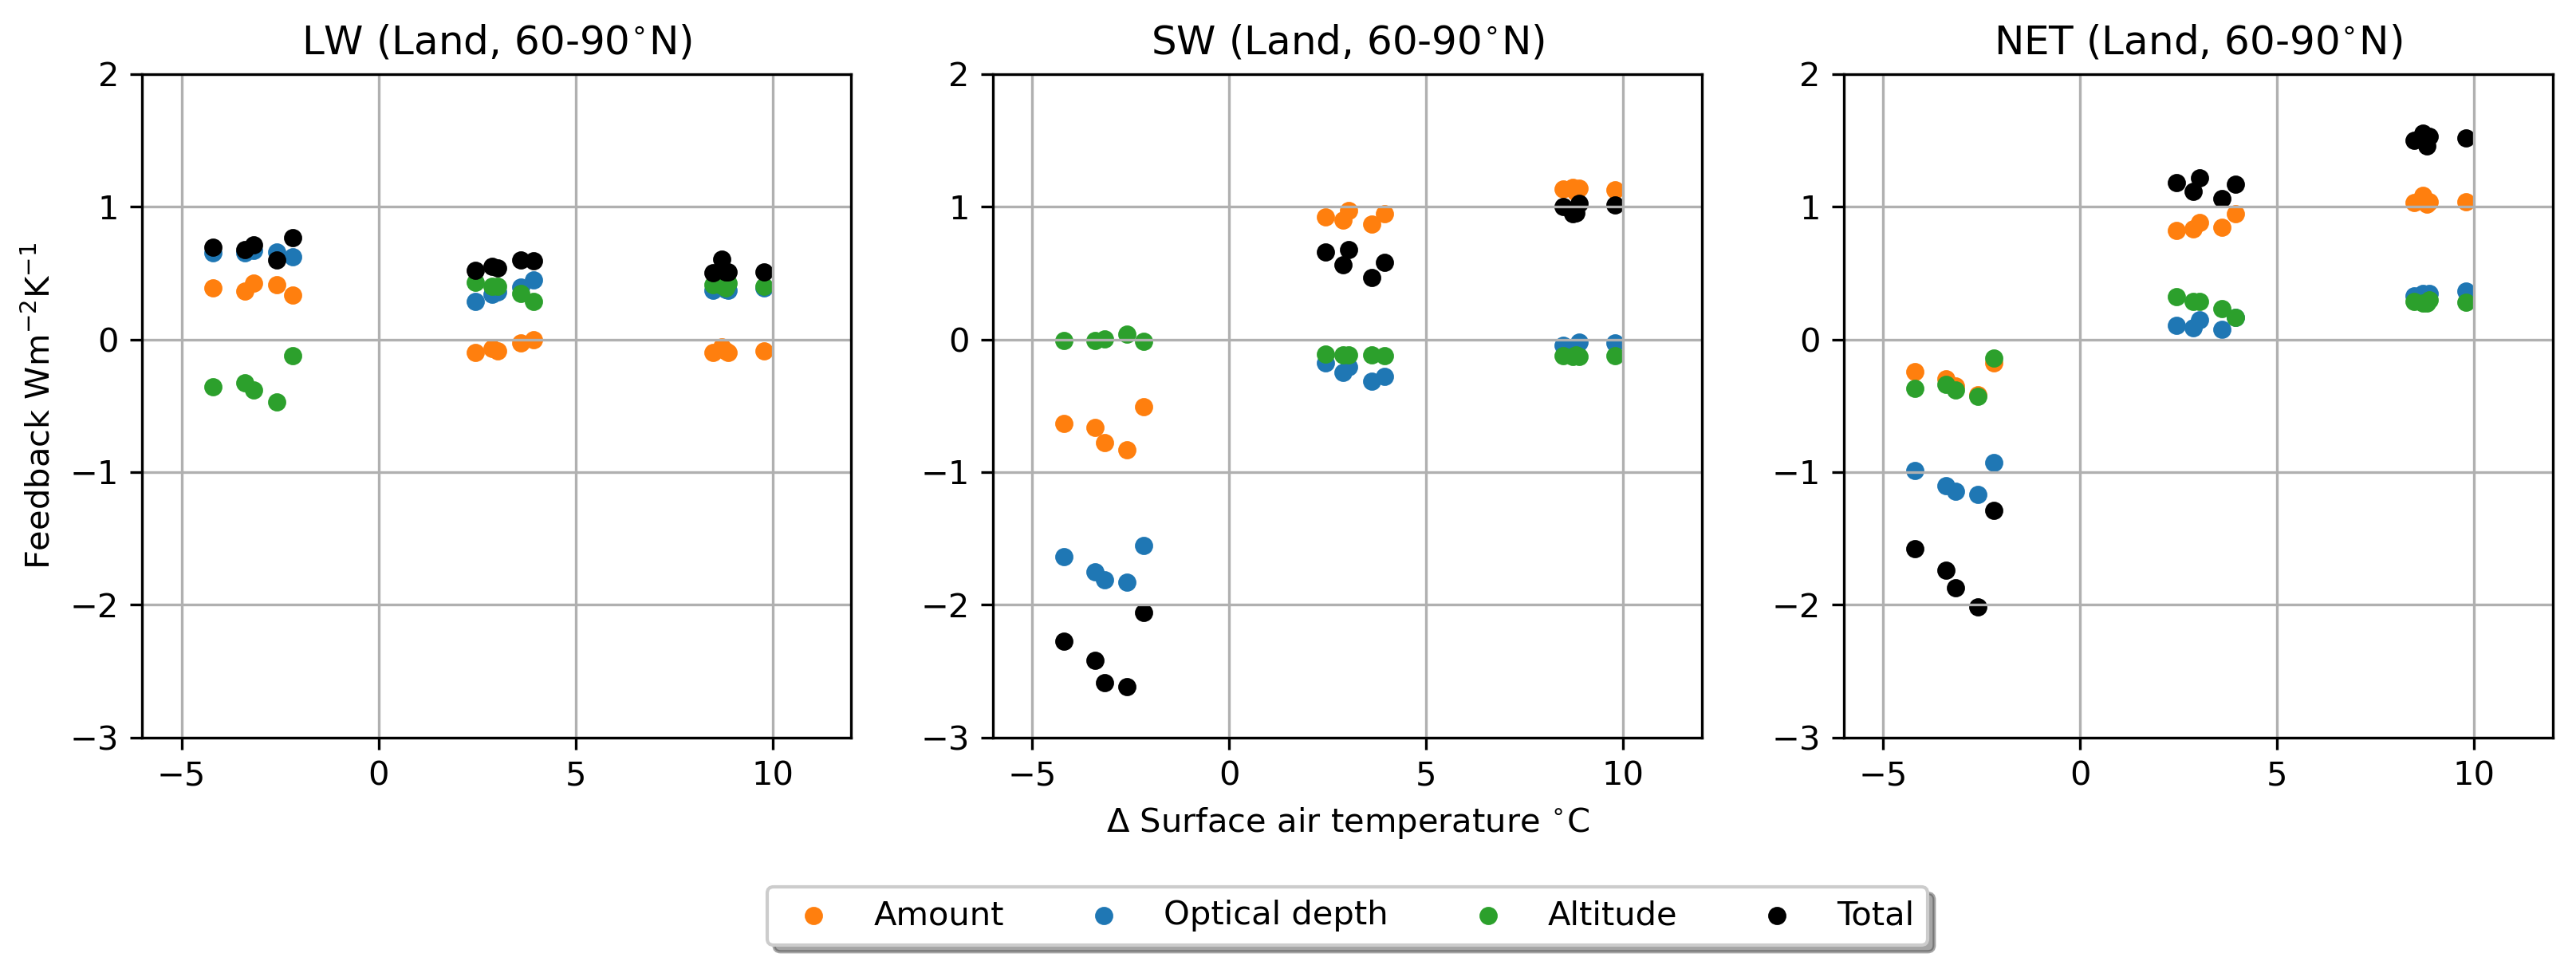

In [8]:
MASK_LAND = True
components = ['LW', 'SW', 'NET']
variables = ['amt', 'tau', 'alt', 'err']
variables = ['amt', 'tau', 'alt']
var_labels = ['Amount', 'Optical depth', 'Altitude']
var_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
var_colors = ['tab:orange', 'tab:blue', 'tab:green',]
exp_linestyles = ['-', '--', '-.']

Arctic_limit = 60
if MASK_LAND:
    ds_Arctic = functions.computeWeightedMeanMasked(ds.sel(lat=slice(Arctic_limit, 90)),landmask_CRK.sel(lat=slice(Arctic_limit, 90))).mean('time')
    ds_dT_Arctic = functions.computeWeightedMeanMasked(ds_dT.sel(lat=slice(Arctic_limit, 90)),landmask.sel(lat=slice(Arctic_limit, 90))).mean('time')
else:
    ds_Arctic = functions.computeWeightedMeanMasked(ds.sel(lat=slice(Arctic_limit, 90)),oceanmask_CRK.sel(lat=slice(Arctic_limit, 90))).mean('time')
    ds_dT_Arctic = functions.computeWeightedMeanMasked(ds_dT.sel(lat=slice(Arctic_limit, 90)),oceanmask.sel(lat=slice(Arctic_limit, 90))).mean('time')


fig, axs = plt.subplots(1,3, figsize=(13, 4), dpi=300)
for i in range(len(ds_Arctic.co2_conc)):
    for j in range(len(components)):
        comp = components[j]
        for var, color, label in zip(variables, var_colors, var_labels):
            if i == 0: # add label
                axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_'+var].isel(co2_conc=i), color=color, label=label, linestyle='-', s=20)
            else:
                axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_'+var].isel(co2_conc=i), color=color, linestyle='-', s=20)
        if i == 0: # add label
            axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_tot'].isel(co2_conc=i), color='black', label='Total', linestyle='-', s=20)
        else:
            axs[j].scatter(ds_dT_Arctic['tas'].isel(co2_conc=i), ds_Arctic[comp+'cld_tot'].isel(co2_conc=i), color='black', linestyle='-', s=20)

for i in range(len(axs)):
    if MASK_LAND:
        axs[i].set_title(components[i]+' (Land, '+str(Arctic_limit)+'-90$^{\circ}$N)')
    else:
        axs[i].set_title(components[i]+' (Ocean, '+str(Arctic_limit)+'-90$^{\circ}$N)')
    axs[i].set_ylim([-3, 2])
    axs[i].set_xlim([-6, 12])
    axs[i].grid()

    # Shrink bokx size to make room for legend
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

axs[0].set_ylabel('Feedback Wm$^{-2}$K$^{-1}$')
axs[1].set_xlabel('$\Delta$ Surface air temperature $^{\circ}$C')
# Put a legend below middle axis
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)


In [10]:
def computeSeasonalMean(ds, season):

    # Author: Astrid Bragstad Gjelsvik
    # Works for xarray datasets with monthly averages as time axis

    import xarray as xr
    if season == 'DJF':
        ds_season = xr.concat([ds.isel(time=slice(1, 2)), ds.isel(time=12)], dim='time')
        ds_season = ds_season.mean('time')
        return ds_season
    elif season == 'MAM':
        ds_season = ds.isel(time=slice(3, 5))
        ds_season = ds_season.mean('time')
        return ds_season
    elif season == 'JJA':
        ds_season = ds.isel(time=slice(6, 8))
        ds_season = ds_season.mean('time')
        return ds_season
    elif season == 'SON':
        ds_season = ds.isel(time=slice(9, 11))
        ds_season = ds_season.mean('time')
        return ds_season
    else:
        print('Please provide a season on the form "JJA", "DJF", "MAM" or "SON"')

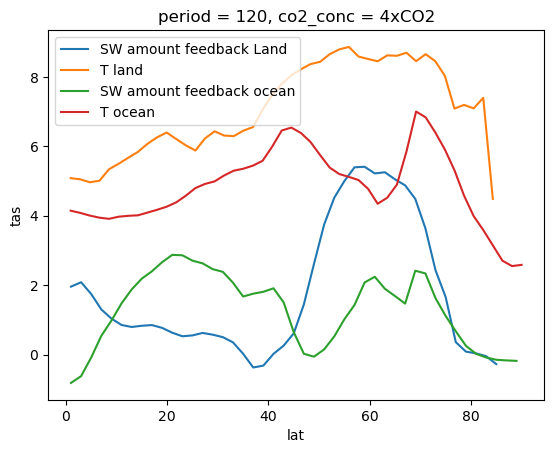

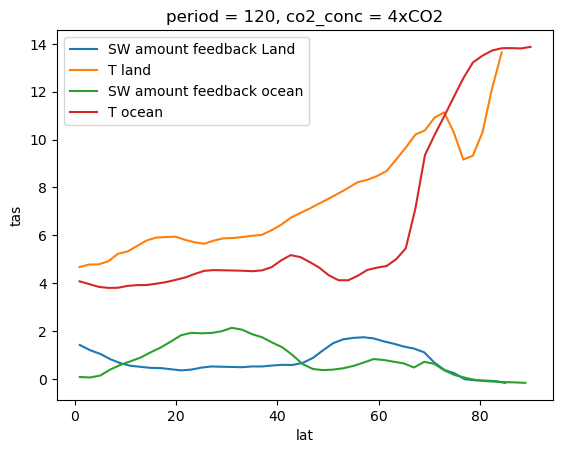

In [13]:
season ='JJA'
period=120
var = 'SWcld_amt'
co2_conc = '4xCO2'

ds_land_zonal = (ds.sel(period=period, co2_conc=co2_conc).weighted(landmask_CRK)).mean('lon')
ds_land_zonal_s = computeSeasonalMean(ds_land_zonal, season)
ds_land_zonal_a = ds_land_zonal.mean('time')

ds_ocean_zonal = (ds.sel(period=period, co2_conc=co2_conc).weighted(oceanmask_CRK)).mean('lon')
ds_ocean_zonal_s = computeSeasonalMean(ds_ocean_zonal, season)
ds_ocean_zonal_a = ds_ocean_zonal.mean('time')

dT_land_zonal = (ds_dT.sel(period=period,co2_conc=co2_conc).weighted(landmask)).mean('lon')
dT_land_zonal_s = computeSeasonalMean(dT_land_zonal, season)
dT_land_zonal_a = dT_land_zonal.mean('time')

dT_ocean_zonal = (ds_dT.sel(period=period,co2_conc=co2_conc).weighted(oceanmask)).mean('lon')
dT_ocean_zonal_s = computeSeasonalMean(dT_ocean_zonal, season)
dT_ocean_zonal_a = dT_ocean_zonal.mean('time')

plt.figure()
ds_land_zonal_s[var].sel(lat=slice(0,90)).plot(label='SW amount feedback Land')
dT_land_zonal_s['tas'].sel(lat=slice(0,90)).plot(label='T land')

ds_ocean_zonal_s[var].sel(lat=slice(0,90)).plot(label='SW amount feedback ocean')
dT_ocean_zonal_s['tas'].sel(lat=slice(0,90)).plot(label='T ocean')
plt.legend()
plt.show()

plt.figure()
ds_land_zonal_a[var].sel(lat=slice(0,90)).plot(label='SW amount feedback Land')
dT_land_zonal_a['tas'].sel(lat=slice(0,90)).plot(label='T land')

ds_ocean_zonal_a[var].sel(lat=slice(0,90)).plot(label='SW amount feedback ocean')
dT_ocean_zonal_a['tas'].sel(lat=slice(0,90)).plot(label='T ocean')
plt.legend()

#ds_Arctic = ,landmask_CRK.sel(lat=slice(Arctic_limit, 90))).mean('time')
#ds_dT_Arctic = functions.computeWeightedMeanMasked(ds_dT.sel(lat=slice(Arctic_limit, 90)),landmask.sel(lat=slice(Arctic_limit, 90))).mean('time')

    #air_weighted = ds.weighted(weights)
    #weighted_mean = air_weighted.mean(("lon", "lat"))

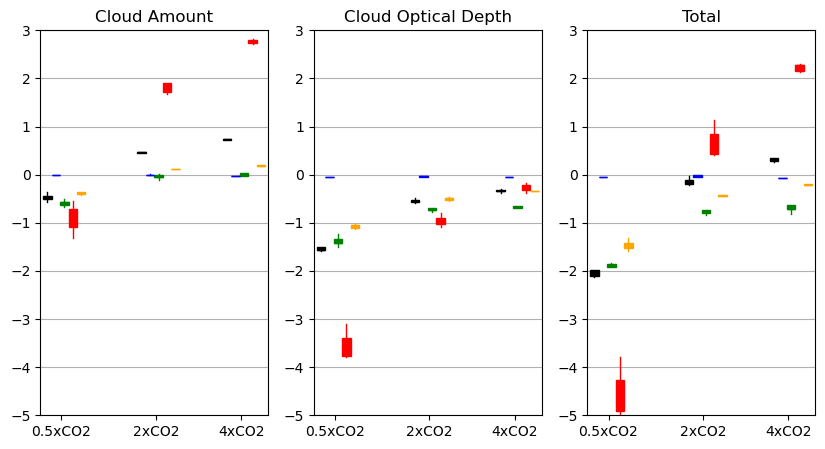

In [122]:
Arctic_limit = 60
ds_Arctic = functions.computeWeightedMean(ds.sel(lat=slice(Arctic_limit, 90)))
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit, 90)))

# Compute seasonal temperature means
dT_seasons = []
seasons = ['DJF','MAM','JJA','SON']; colors=['blue', 'green','red','orange']
for season in seasons:
    ds_i = functions.computeSeasonalMean(ds_dT_Arctic,season)
    dT_seasons.append(ds_i)

dT_seasons = xr.concat(dT_seasons, dim='season')
dT_seasons = dT_seasons.assign_coords({'season':seasons})

# Compute seasonal feedback means
ds_seasons = ds_Arctic.groupby('time.season').mean('time')

width=0.6

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
comps = ['amt', 'tau','tot']; comp_names = ['Cloud Amount','Cloud Optical Depth','Total']
for ax, comp, name in zip(axs.flatten(), comps, comp_names):
        ax.set_title(name)
        # Plot annual average
        ann_avg = ds_seasons['SWcld_'+comp].mean('season').T
        dT_ann_avg = dT_seasons['tas'].mean(('season','period'))
        ax.boxplot(ann_avg, positions = dT_ann_avg, widths=width,orientation='vertical',
                   showcaps=False, patch_artist=True,
                   boxprops=dict(facecolor='black', color='black'),
                   medianprops=dict(color='black'),
                   whiskerprops=dict(color='black'),
                   flierprops=dict(color='black',markeredgecolor='black'), sym='')
        ax.set_ylim([-5,3])
        ax.grid(axis='y')
        # Plot season values
        i=0
        for season, color in zip(seasons, colors):
            i+=width
            season_avg = ds_seasons['SWcld_'+comp].sel(season=season).T
            dT_season_avg = dT_seasons['tas'].sel(season=season).mean('period')
            ax.boxplot(season_avg, positions = dT_ann_avg+i, widths=width, orientation='vertical',
                       showcaps=False, patch_artist=True,
                       boxprops=dict(facecolor=color, color=color),
                       medianprops=dict(color=color),
                       whiskerprops=dict(color=color),
                       flierprops=dict(color=color,markeredgecolor=color),sym='')
        
        ax.set_xticks(dT_ann_avg+1)
        ax.set_xticklabels(ds.co2_conc.values)

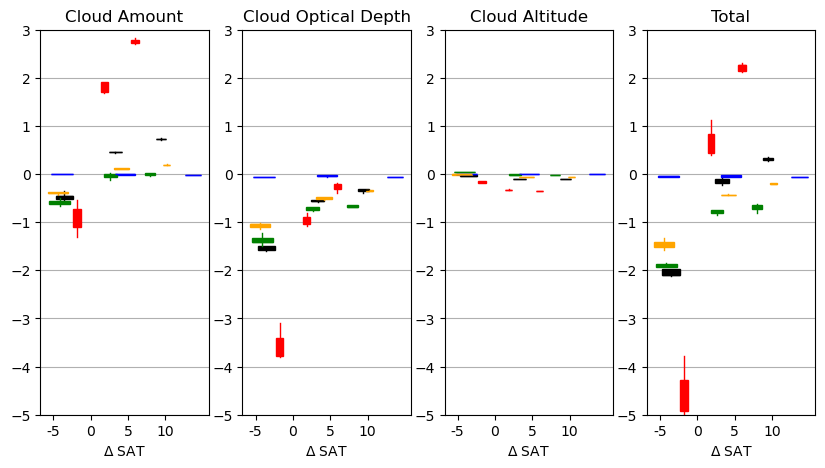

In [125]:
Arctic_limit = 60
ds_Arctic = functions.computeWeightedMean(ds.sel(lat=slice(Arctic_limit, 90)))
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit, 90)))

# Compute seasonal temperature means
dT_seasons = []
seasons = ['DJF','MAM','JJA','SON']; colors=['blue', 'green','red','orange']
for season in seasons:
    ds_i = functions.computeSeasonalMean(ds_dT_Arctic,season)
    dT_seasons.append(ds_i)

dT_seasons = xr.concat(dT_seasons, dim='season')
dT_seasons = dT_seasons.assign_coords({'season':seasons})

# Compute seasonal feedback means
ds_seasons = ds_Arctic.groupby('time.season').mean('time')

width=0.6

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
comps = ['amt', 'tau', 'alt','tot']; comp_names = ['Cloud Amount','Cloud Optical Depth', 'Cloud Altitude','Total']
for ax, comp, name in zip(axs.flatten(), comps, comp_names):
        ax.set_title(name)
        # Plot annual average
        ann_avg = ds_seasons['SWcld_'+comp].mean('season').T
        dT_ann_avg = dT_seasons['tas'].mean(('season'))
        dT_ann_min = dT_ann_avg.min('period').values
        dT_ann_range = dT_ann_avg.max('period').values - dT_ann_min
        ax.boxplot(ann_avg, positions = dT_ann_min+0.5*dT_ann_range, widths=dT_ann_range,orientation='vertical',
                   showcaps=False, patch_artist=True,
                   boxprops=dict(facecolor='black', color='black'),
                   medianprops=dict(color='black'),
                   whiskerprops=dict(color='black'),
                   flierprops=dict(color='black',markeredgecolor='black'), sym='')
        ax.set_ylim([-5,3])
        ax.grid(axis='y')
        # Plot season values
        i=0
        for season, color in zip(seasons, colors):
            i+=width
            season_avg = ds_seasons['SWcld_'+comp].sel(season=season).T
            dT_season_min = dT_seasons['tas'].sel(season=season).min('period').values
            dT_season_range = dT_seasons['tas'].sel(season=season).max('period').values - dT_season_min
            #print(season+', ',dT_season_range.values)
            ax.boxplot(season_avg, positions = dT_season_min+0.5*dT_season_range, widths=dT_season_range, orientation='vertical',
                       showcaps=False, patch_artist=True,
                       boxprops=dict(facecolor=color, color=color),
                       medianprops=dict(color=color),
                       whiskerprops=dict(color=color),
                       flierprops=dict(color=color,markeredgecolor=color),sym='')
        
        ax.set_xticks([-5,0,5,10])
        ax.set_xticklabels([-5,0,5,10])
        ax.set_xlabel('$\Delta$ SAT')

/tmp/ipykernel_1837361/2628631002.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ds_seasons.season.values, fontsize=12)
/tmp/ipykernel_1837361/2628631002.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ds_seasons.season.values, fontsize=12)
/tmp/ipykernel_1837361/2628631002.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ds_seasons.season.values, fontsize=12)


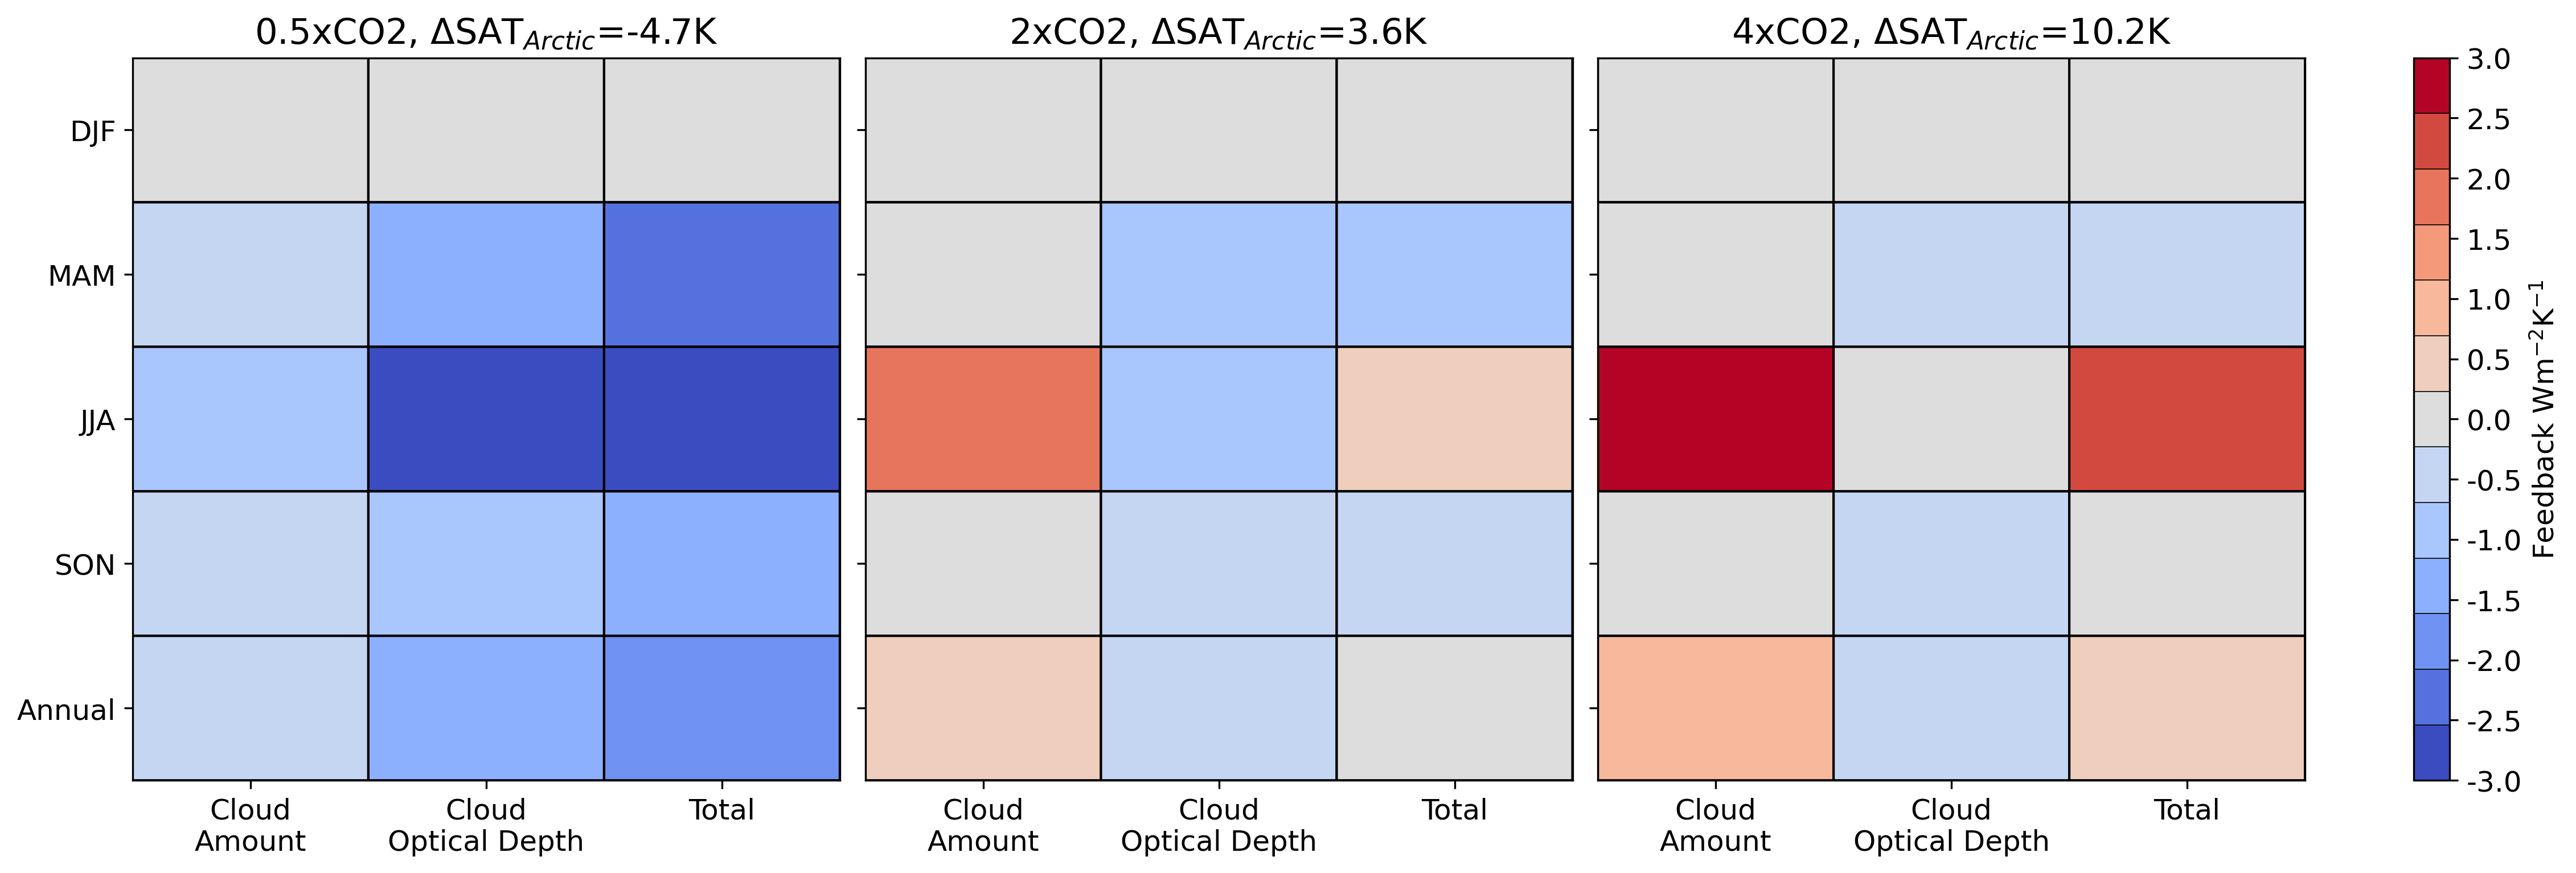

In [150]:
Arctic_limit = 60
period = 120
ds_Arctic = functions.computeWeightedMean(ds.sel(lat=slice(Arctic_limit, 90),period=period))
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit, 90),period=period))

# Compute seasonal means
# for feedbacks
ds_seasons = ds_Arctic.groupby('time.season').mean('time')
# for temperature changes
ds_list = []
dT_seasons = []
seasons = ['DJF','MAM','JJA','SON']
for season in seasons:
    ds_list.append(ds_seasons.sel(season=season).drop_vars('season'))
    ds_dT_i = functions.computeSeasonalMean(ds_dT_Arctic,season)
    dT_seasons.append(ds_dT_i)

# Compute annual average and concatenate to seasonal means
# for feedbacks
ds_list.append(ds_Arctic.mean('time'))
ds_seasons = xr.concat(ds_list, dim='season')
ds_seasons = ds_seasons.assign_coords({'season':seasons+['Annual']})
#for temperature changes
dT_seasons.append(ds_dT_Arctic.mean('time'))
dT_seasons = xr.concat(dT_seasons, dim='season')
dT_seasons = dT_seasons.assign_coords({'season':seasons+['Annual']})

fig, axs = plt.subplots(1, 3, figsize=(15, 5),dpi=300,sharey=True, constrained_layout=True)
comps = ['amt', 'tau','tot']; comp_names = ['Cloud\nAmount','Cloud\nOptical Depth', 'Total']
ds_list = []
for comp in comps:
      ds_list.append(ds_seasons['SWcld_'+comp])
ds_seasons = xr.merge(ds_list)
for ax, co2_conc in zip(axs.flatten(), ds.co2_conc.values):
        d_SAT = dT_seasons['tas'].sel(season='Annual',co2_conc=co2_conc).values
        ax.set_title(co2_conc+', $\Delta$SAT$_{Arctic}$='+str(np.round(d_SAT,1))+'K', fontsize=15)
        ds_seasons_i = ds_seasons.sel(co2_conc=co2_conc)
        ds_seasons_i = ds_seasons_i.to_dataarray()
        X = np.arange(len(comps))
        Y = ds_seasons.season
        cmap = ax.pcolor(X, Y, ds_seasons_i.T, cmap=plt.get_cmap('coolwarm',13),vmin=-3, vmax=3,edgecolor='k',linewidths=1)
        ax.set_xticks(np.arange(len(comps)))
        ax.set_xticklabels(comp_names,fontsize=12)
        ax.set_yticklabels(ds_seasons.season.values, fontsize=12)
        ax.invert_yaxis()
import matplotlib as mpl
cax,kw = mpl.colorbar.make_axes([ax for ax in axs.flat])
cb = plt.colorbar(cmap, cax=cax, **kw, ticks=np.linspace(-3,3,13),drawedges=True)
cb.set_label(label='Feedback Wm$^{-2}$K$^{-1}$',fontsize=12)
cb.set_ticklabels(ticklabels=np.linspace(-3,3,13),fontsize=12)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
#fig.colorbar(cmap, cax=cbar_ax)
#fig.tight_layout()

In [4]:
clouddir = '/projects/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/'
tempdir = '/projects/NS9600K/astridbg/arctic-cld-feedbacks/data/feedback_input/'
var_list = ['CLDTOT']

In [5]:
# Prepare piClim experiments
exp = 'piClim'
tslice = slice('2040-01-01', '2069-12-31')

pi_temp = xr.open_dataset(tempdir+'tas_piClim_final30years.nc')
pi_temp = functions.computeWeightedMean(pi_temp.mean('time'))
pi_temp = float(pi_temp['tas'].values)

cloud_files = []
for var in var_list: cloud_files.append(clouddir+var+'_'+exp+'.nc')
cloud_files.sort()
print(cloud_files)
cloud_ds = xr.open_mfdataset(cloud_files)

cloud_slice = cloud_ds.sel(time=tslice)
piClim_cloud = cloud_slice.groupby('time.month').mean('time')
piClim_cloud = piClim_cloud.rename({'month':'time'})

['/projects/NS9600K/astridbg/arctic-cld-feedbacks/data/other_cloud_vars/CLDTOT_piClim.nc']


In [6]:
experiments = ['abrupt-0_5xCO2', 'abrupt-2xCO2', 'abrupt-4xCO2']
interval = 30
ds_list = []
dT_list = []

interval=30
if interval == 30:
    tslicelist = [slice('1920-01-01', '1949-12-31'), slice('1950-01-01', '1979-12-31'),
                slice('1980-01-01', '2009-12-31'), slice('2010-01-01', '2039-12-31'),
                slice('2040-01-01', '2069-12-31')]
elif interval==15:
    tslicelist = [slice('1920-01-01', '1934-12-31'), slice('1935-01-01', '1949-12-31'),
                slice('1950-01-01', '1964-12-31'), slice('1965-01-01', '1979-12-31'),
                slice('1980-01-01', '1994-12-31'), slice('1995-01-01', '2009-12-31'),
                slice('2010-01-01', '2024-12-31'), slice('2025-01-01', '2039-12-31'),
                slice('2040-01-01', '2054-12-31'), slice('2055-01-01', '2069-12-31')]
elif interval==10:
    tslicelist = [slice('1920-01', '1929-12'), slice('1930-01-01', '1939-12-31'),
            slice('1940-01-01', '1949-12-31'), slice('1950-01-01', '1959-12-31'),
            slice('1960-01-01', '1969-12-31'), slice('1970-01-01', '1979-12-31'),
            slice('1980-01-01', '1989-12-31'), slice('1990-01-01', '1999-12-31'),
            slice('2000-01-01', '2009-12-31'), slice('2010-01-01', '2019-12-31'),
            slice('2020-01-01', '2029-12-31'), slice('2030-01-01', '2039-12-31'),
            slice('2040-01-01', '2049-12-31'), slice('2050-01-01', '2059-12-31'),
            slice('2060-01-01', '2069-12-31')]
N = int(150/interval)

pi_temp = xr.open_dataset(tempdir+'tas_piClim_final30years.nc')
pi_temp = pi_temp.groupby('time.month').mean('time')
pi_temp = pi_temp.rename({'month':'time'})
pi_temp_annavg = pi_temp.mean('time')

for exp in experiments:
    cloud_files = []
    for var in var_list: cloud_files.append(clouddir+var+'_'+exp+'.nc')
    cloud_files.sort()
    cloud_ds = xr.open_mfdataset(cloud_files)

    temp_ds = xr.open_dataset(tempdir+'tas_'+exp+'_1920-01-01_2069-12-31.nc')
    
    dT = []
    cloud_list = []
    for tslice in tslicelist:
        cloud_slice = cloud_ds.sel(time=tslice)
        cloud_slice = cloud_slice.groupby('time.month').mean('time')
        cloud_slice = cloud_slice.rename({'month':'time'})
        cloud_list.append(cloud_slice)


        temp_slice = temp_ds.sel(time=tslice)
        temp_slice = temp_slice.groupby('time.month').mean('time')
        temp_slice = temp_slice.rename({'month':'time'})
        temp_slice['tas'] = temp_slice['tas'] - pi_temp['tas']
        dT.append(temp_slice)
    
    ds_cloud = xr.concat(cloud_list, dim='period')
    ds_list.append(ds_cloud)

    dT = xr.concat(dT, dim='period')
    dT_list.append(dT)

ds_cloud = xr.concat(ds_list, dim='co2_conc')
ds_cloud = ds_cloud.assign_coords({'period':np.arange(N)*interval})
ds_cloud = ds_cloud.assign_coords({'co2_conc':['0.5xCO2', '2xCO2', '4xCO2']})


ds_dT_cloud = xr.concat(dT_list, dim='co2_conc')
ds_dT_cloud = ds_dT_cloud.assign_coords({'period':np.arange(N)*interval})
ds_dT_cloud = ds_dT_cloud.assign_coords({'co2_conc':['0.5xCO2', '2xCO2', '4xCO2']})

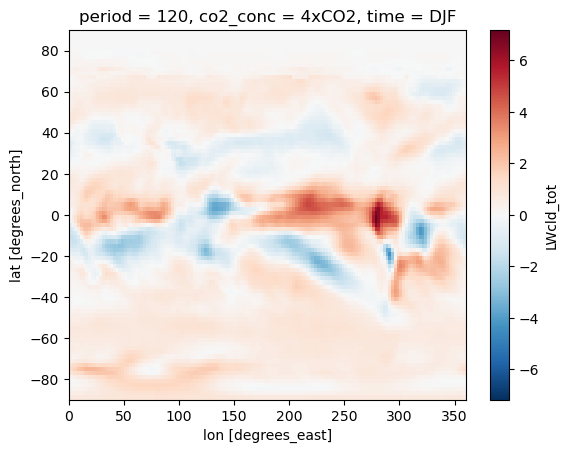

In [316]:
Arctic_limit = 60
period = 120

seasons = ['DJF','MAM','JJA','SON']
components = ['LWcld_amt', 'LWcld_tau','LWcld_tot']; component_names = ['Cloud\nAmount','Cloud\nOptical\nDepth', 'Total']

labels = [['(a)','(b)','(c)'],['(d)','(e)','(f)'], ['(g)','(h)','(i)']]

# Choose subset of feedback variables, while selecting period of interest
var_list = []
for comp in components:
      var_list.append(ds[comp].sel(period=period)) 
feedbacks = xr.merge(var_list)

# Compute seasonal means and annual average
feedbacks_t_avg = [] # for feedbacks
cloud_t_avg = [] # for cloud cover
cloud_piClim_t_avg = [] # for pre-industrial cloud cover
temp_t_avg = [] # for temperature

feedbacks_seasons = feedbacks.groupby('time.season').mean('time')
for season in seasons:
    cloud_i = functions.computeSeasonalMean(ds_cloud.sel(period=period),season=season)
    cloud_piClim_i = functions.computeSeasonalMean(piClim_cloud,season=season)
    dT_i = functions.computeSeasonalMean(ds_dT.sel(period=period),season=season)

    feedbacks_t_avg.append(feedbacks_seasons.sel(season=season).drop_vars('season'))
    cloud_t_avg.append(cloud_i)
    cloud_piClim_t_avg.append(cloud_piClim_i)
    temp_t_avg.append(dT_i)
feedbacks_t_avg.append(feedbacks.mean('time'))
cloud_t_avg.append(ds_cloud.sel(period=period).mean('time'))
cloud_piClim_t_avg.append(piClim_cloud.mean('time'))
temp_t_avg.append(ds_dT.sel(period=period).mean('time'))

feedbacks_t_avg = xr.concat(feedbacks_t_avg,dim='time')
feedbacks_t_avg = feedbacks_t_avg.assign_coords({'time':seasons+['Annual']})

cloud_t_avg = xr.concat(cloud_t_avg,dim='time')
cloud_t_avg = cloud_t_avg.assign_coords({'time':seasons+['Annual']})

cloud_piClim_t_avg = xr.concat(cloud_piClim_t_avg,dim='time')
cloud_piClim_t_avg = cloud_piClim_t_avg.assign_coords({'time':seasons+['Annual']})

feedbacks_t_avg['LWcld_tot'].sel(co2_conc='4xCO2',time='DJF').plot()

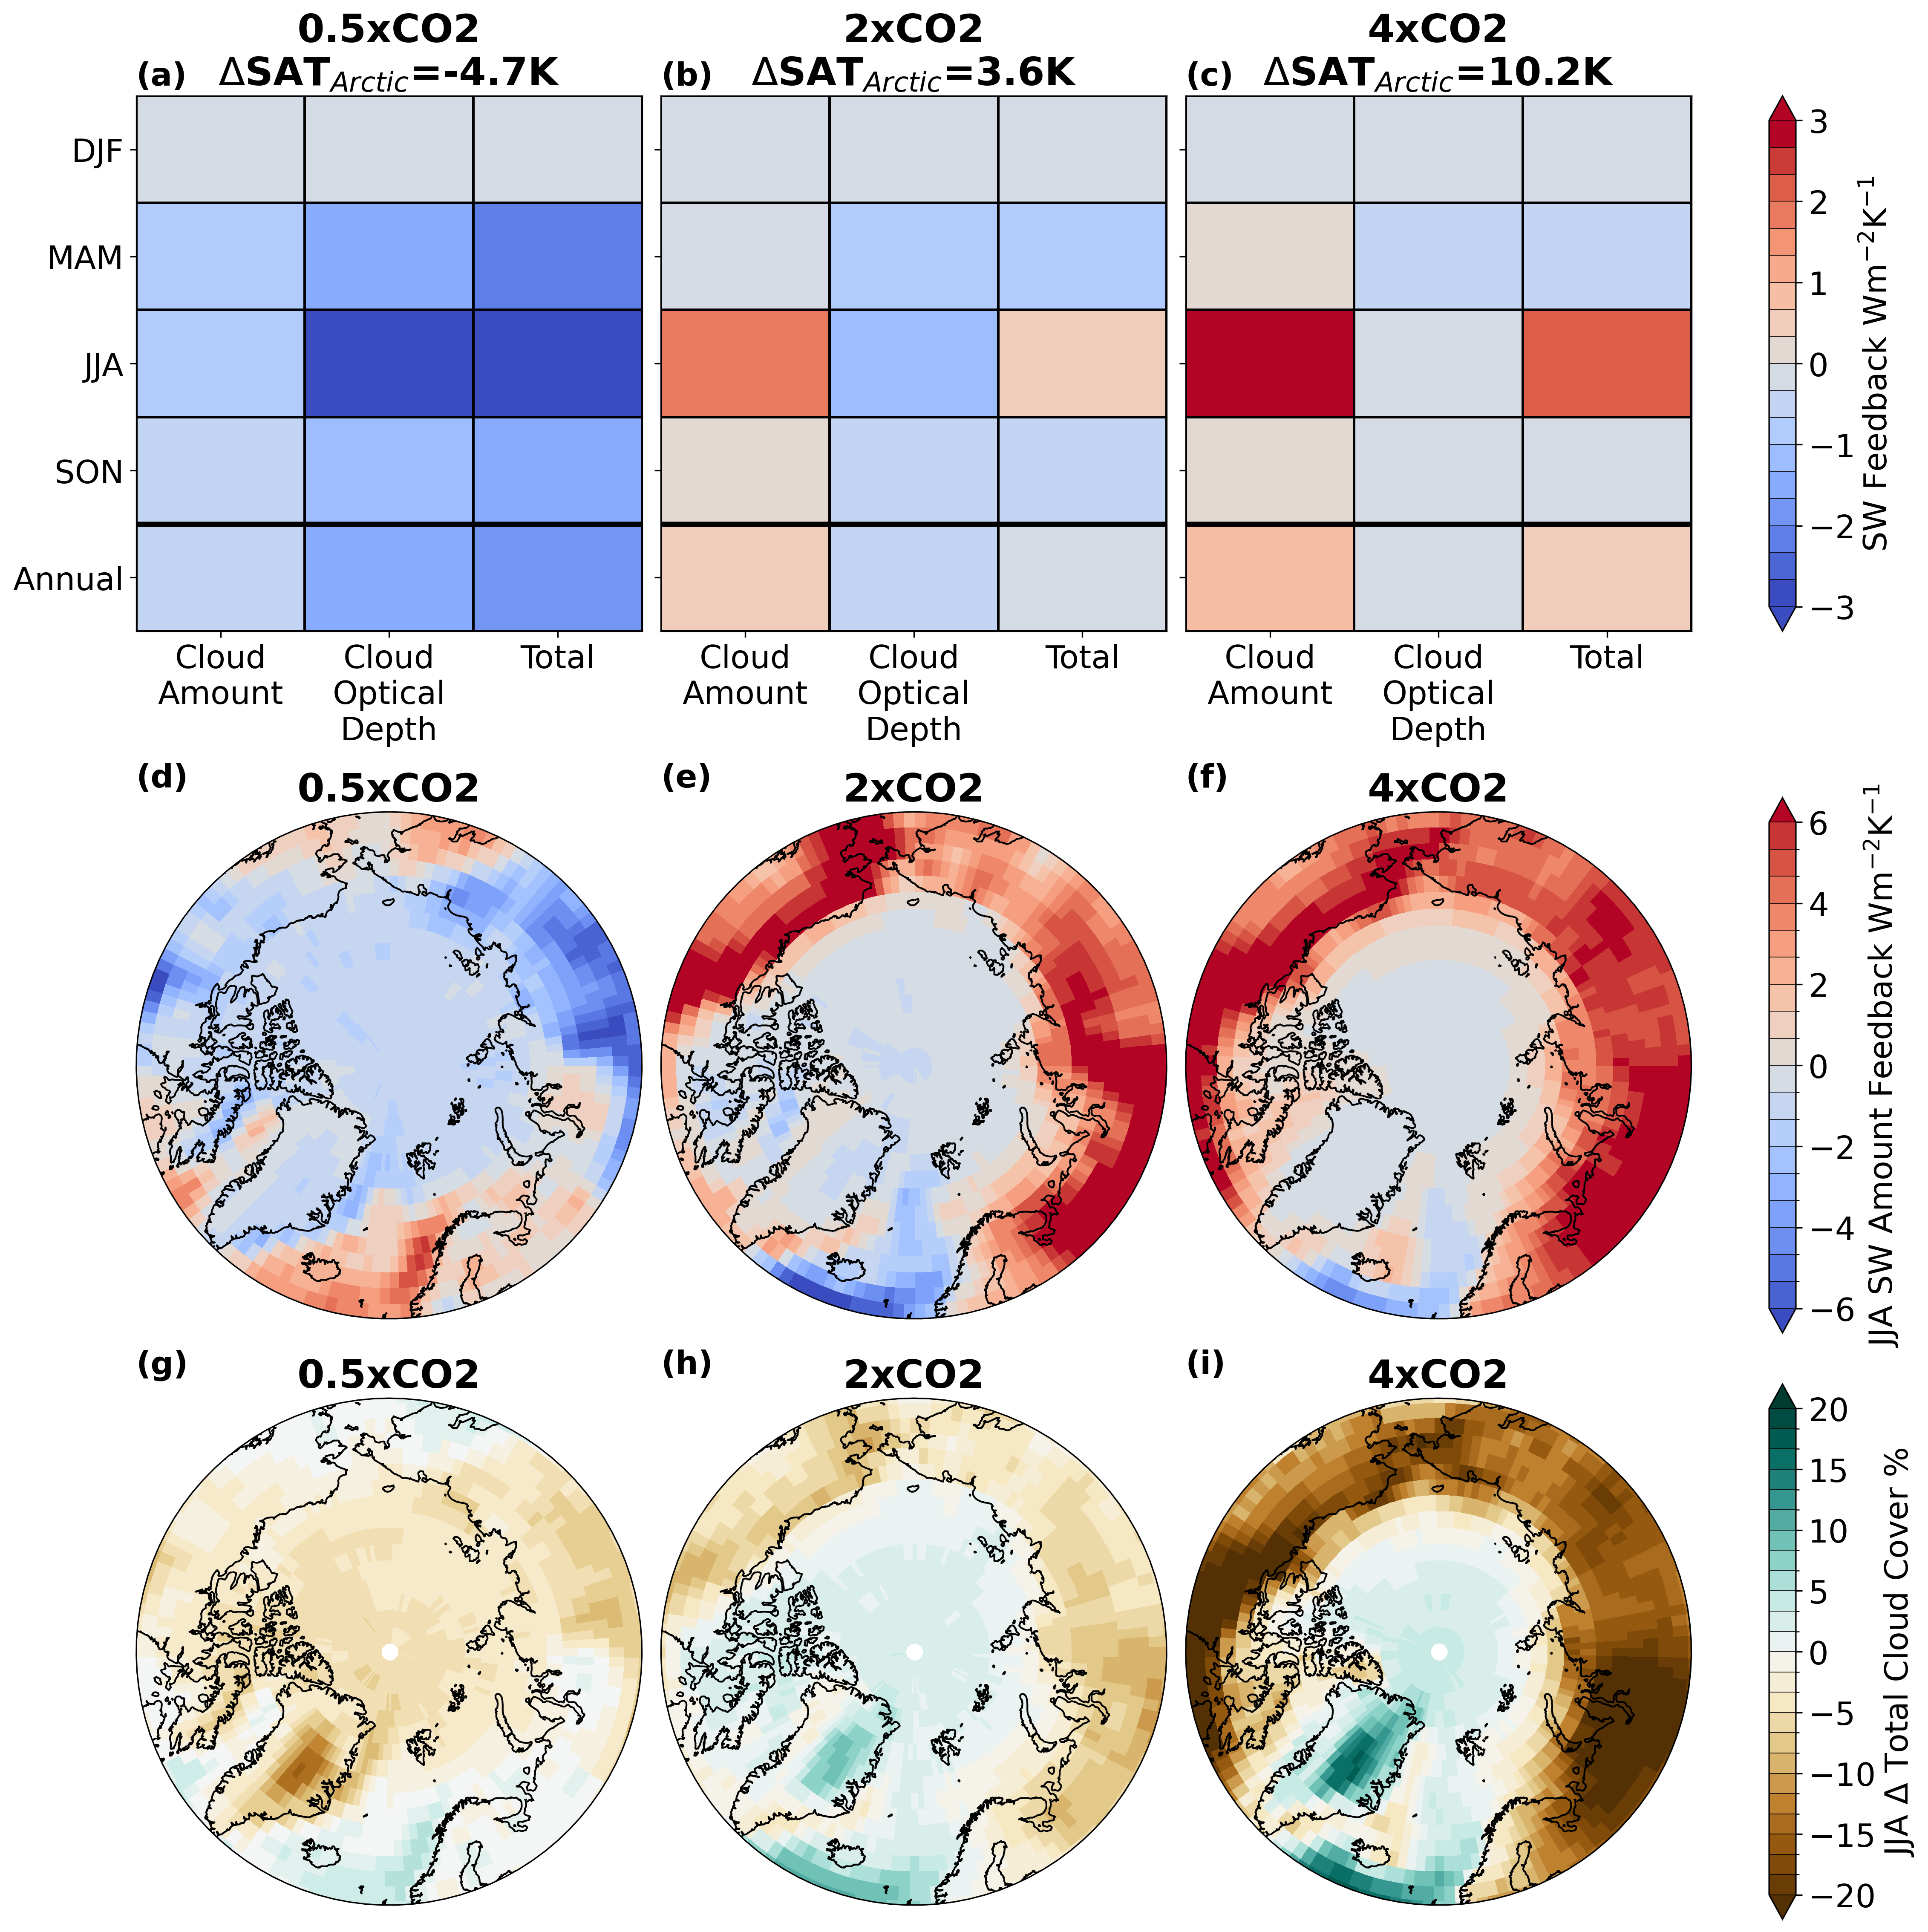

In [7]:
Arctic_limit = 60
period = 120

seasons = ['DJF','MAM','JJA','SON']
components = ['SWcld_amt', 'SWcld_tau','SWcld_tot']; component_names = ['Cloud\nAmount','Cloud\nOptical\nDepth', 'Total']

labels = [['(a)','(b)','(c)'],['(d)','(e)','(f)'], ['(g)','(h)','(i)']]

# Choose subset of feedback variables, while selecting period of interest
var_list = []
for comp in components:
      var_list.append(ds[comp].sel(period=period)) 
feedbacks = xr.merge(var_list)

# Compute seasonal means and annual average
feedbacks_t_avg = [] # for feedbacks
cloud_t_avg = [] # for cloud cover
cloud_piClim_t_avg = [] # for pre-industrial cloud cover
temp_t_avg = [] # for temperature

feedbacks_seasons = feedbacks.groupby('time.season').mean('time')
for season in seasons:
    cloud_i = functions.computeSeasonalMean(ds_cloud.sel(period=period),season=season)
    cloud_piClim_i = functions.computeSeasonalMean(piClim_cloud,season=season)
    dT_i = functions.computeSeasonalMean(ds_dT.sel(period=period),season=season)

    feedbacks_t_avg.append(feedbacks_seasons.sel(season=season).drop_vars('season'))
    cloud_t_avg.append(cloud_i)
    cloud_piClim_t_avg.append(cloud_piClim_i)
    temp_t_avg.append(dT_i)
feedbacks_t_avg.append(feedbacks.mean('time'))
cloud_t_avg.append(ds_cloud.sel(period=period).mean('time'))
cloud_piClim_t_avg.append(piClim_cloud.mean('time'))
temp_t_avg.append(ds_dT.sel(period=period).mean('time'))

feedbacks_t_avg = xr.concat(feedbacks_t_avg,dim='time')
feedbacks_t_avg = feedbacks_t_avg.assign_coords({'time':seasons+['Annual']})

cloud_t_avg = xr.concat(cloud_t_avg,dim='time')
cloud_t_avg = cloud_t_avg.assign_coords({'time':seasons+['Annual']})

cloud_piClim_t_avg = xr.concat(cloud_piClim_t_avg,dim='time')
cloud_piClim_t_avg = cloud_piClim_t_avg.assign_coords({'time':seasons+['Annual']})

temp_t_avg = xr.concat(temp_t_avg,dim='time')
temp_t_avg = temp_t_avg.assign_coords({'time':seasons+['Annual']})

# Compute Arctic spatial averages
feedbacks_Arctic = functions.computeWeightedMean(feedbacks_t_avg.sel(lat=slice(Arctic_limit, 90)))
temp_Arctic = functions.computeWeightedMean(temp_t_avg.sel(lat=slice(Arctic_limit, 90)))

# Create figure
fig, axs = plt.subplot_mosaic(mosaic=labels, figsize=(15, 15),dpi=300,sharey=True,constrained_layout=True)
# Remove axis from map plots
for label in labels[1]+labels[2]:
      ax = axs[label]
      ax.axis('off')
# Add new subplots with Arctic map projection
ax4 = fig.add_subplot(3, 3, 4, projection=ccrs.Orthographic(0, 90))
ax5 = fig.add_subplot(3, 3, 5, projection=ccrs.Orthographic(0, 90))
ax6 = fig.add_subplot(3, 3, 6, projection=ccrs.Orthographic(0, 90))
ax7 = fig.add_subplot(3, 3, 7, projection=ccrs.Orthographic(0, 90))
ax8 = fig.add_subplot(3, 3, 8, projection=ccrs.Orthographic(0, 90))
ax9 = fig.add_subplot(3, 3, 9, projection=ccrs.Orthographic(0, 90))

# Row 1: spatially averaged feedback plots
for label, co2_conc in zip(labels[0], ds.co2_conc.values):
        ax = axs[label]
        d_SAT = temp_Arctic['tas'].sel(time='Annual',co2_conc=co2_conc).values
        ax.set_title(co2_conc+'\n$\Delta$SAT$_{Arctic}$='+str(np.round(d_SAT,1))+'K', fontsize=22,fontweight='bold')
        feedbacks_i = feedbacks_Arctic.sel(co2_conc=co2_conc).to_dataarray()
        X = np.arange(len(components))
        Y = np.arange(len(feedbacks_Arctic.time))
        cmap = ax.pcolormesh(X, Y, feedbacks_i.T, cmap=plt.get_cmap('coolwarm',18),vmin=-3,vmax=3,edgecolor='k',linewidths=1)
        ax.hlines(3.5,X[0]-0.5,X[-1]+0.5,color='k',linewidth=3)
        ax.set_xticks(np.arange(len(components)))
        ax.set_xticklabels(component_names,fontsize=18)
        ax.set_yticks(np.arange(len(feedbacks_Arctic.time)))
        ax.set_yticklabels(feedbacks_Arctic.time.values, fontsize=18)
        ax.invert_yaxis()

cax,kw = mpl.colorbar.make_axes([ax for ax in [axs[labels[0][0]],axs[labels[0][1]], axs[labels[0][2]]]])
cb = plt.colorbar(cmap, cax=cax, **kw, ticks=[-3,-2,-1,0,1,2,3],drawedges=True,extend='both')
cb.set_label(label='SW Feedback Wm$^{-2}$K$^{-1}$',fontsize=18)
cb.ax.tick_params(labelsize=18)

# Row 2: spatial distribution of cloud amount feedback
levels=np.linspace(-6, 6, 19)
for ax,co2_conc in zip([ax4, ax5, ax6], ['0.5xCO2', '2xCO2', '4xCO2']):
    functions.polarCentral_set_latlim([60,90], ax)
    data = feedbacks_t_avg['SWcld_amt'].sel(time='JJA', co2_conc=co2_conc)
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='coolwarm', levels=levels,
                                        add_colorbar=False)
    ax.set_title(co2_conc, fontsize=22,fontweight='bold')
    ax.coastlines()

cax,kw = mpl.colorbar.make_axes([ax for ax in [ax4,ax5,ax6]])
cb = plt.colorbar(map, cax=cax, **kw, ticks=[-6,-4,-2,0,2,4,6],drawedges=True)
cb.set_label(label='JJA SW Amount Feedback Wm$^{-2}$K$^{-1}$',fontsize=18)
cb.ax.tick_params(labelsize=18)

# Row 3: spatial distribution of cloud cover change
levels=np.linspace(-20,20,25)
for ax,co2_conc in zip([ax7, ax8, ax9], ['0.5xCO2', '2xCO2', '4xCO2']):
    functions.polarCentral_set_latlim([60,90], ax)
    data = cloud_t_avg['CLDTOT'].sel(time='JJA',co2_conc=co2_conc) - cloud_piClim_t_avg['CLDTOT'].sel(time='JJA') # Get cloud fraction change from pre-industrial climate
    data = data*100 # Convert cloud fraction to percentage
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='BrBG',levels=levels,
                                        add_colorbar=False)
    ax.set_title(co2_conc, fontsize=22,fontweight='bold')
    ax.coastlines()
cax,kw = mpl.colorbar.make_axes([ax for ax in [ax7,ax8,ax9]])
cb = plt.colorbar(map, cax=cax, **kw,ticks=[-20,-15,-10,-5,0,5,10,15,20], drawedges=True)
cb.set_label(label='JJA $\Delta$ Total Cloud Cover %',fontsize=18)
cb.ax.tick_params(labelsize=18)

# Label subplots
for label, ax in axs.items():
    ax.set_title(label, loc='left', fontsize=18,fontweight='bold')

fig.savefig('/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/arctic-cloud-feedbacks/article_figs/Fig1.png')
fig.savefig('/nird/datapeak/NS9600K/astridbg/arctic-cld-feedbacks/arctic-cloud-feedbacks/article_figs/Fig1.pdf')

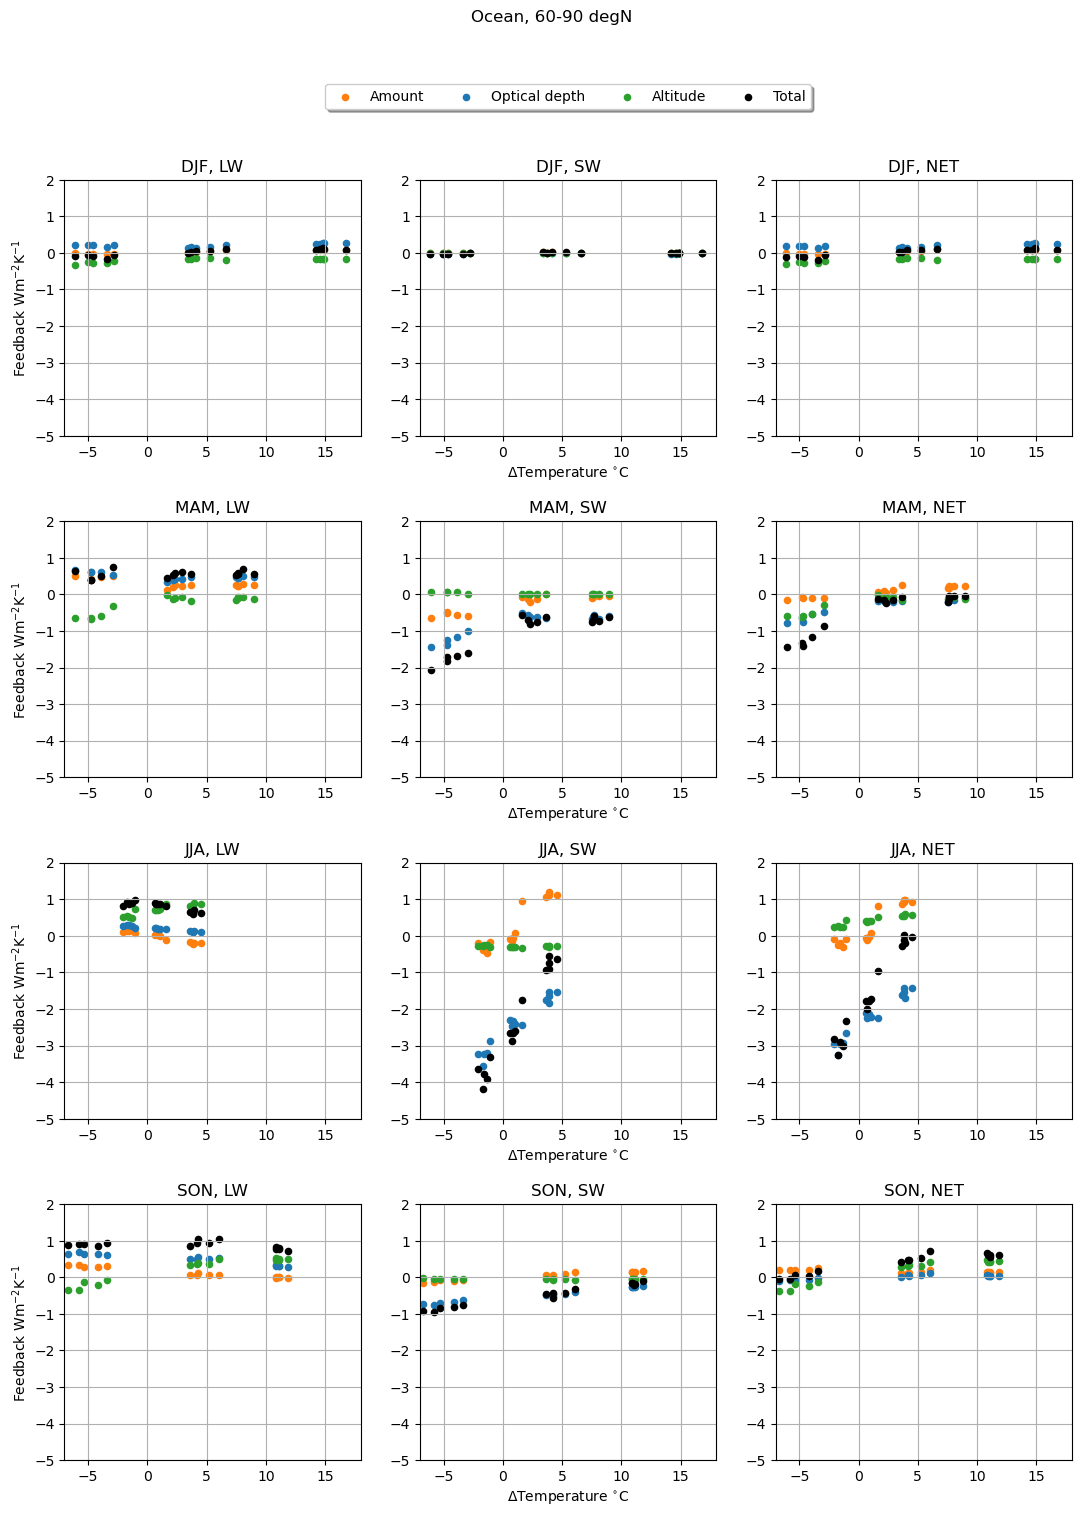

In [49]:
MASK_LAND = False # True = LAND, False = OCEAN
components = ['LW', 'SW', 'NET']
#variables = ['amt', 'tau', 'alt', 'err']
variables = ['amt', 'tau', 'alt']
var_labels = ['Amount', 'Optical depth', 'Altitude']
#var_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
var_colors = ['tab:orange', 'tab:blue', 'tab:green']
seasons = ['DJF', 'MAM', 'JJA', 'SON']

Arctic_limit = 60
if MASK_LAND:
    ds_Arctic = functions.computeWeightedMeanMasked(ds.sel(lat=slice(Arctic_limit, 90)),landmask_CRK.sel(lat=slice(Arctic_limit, 90))).groupby('time.season').mean('time')
    ds_dT_Arctic = functions.computeWeightedMeanMasked(ds_dT.sel(lat=slice(Arctic_limit, 90)),landmask.sel(lat=slice(Arctic_limit, 90)))
else:
    ds_Arctic = functions.computeWeightedMeanMasked(ds.sel(lat=slice(Arctic_limit, 90)),oceanmask_CRK.sel(lat=slice(Arctic_limit, 90))).groupby('time.season').mean('time')
    ds_dT_Arctic = functions.computeWeightedMeanMasked(ds_dT.sel(lat=slice(Arctic_limit, 90)),oceanmask.sel(lat=slice(Arctic_limit, 90)))

fig, axs = plt.subplots(4,3, figsize=(13, 17))
for k in range(len(seasons)):
    ds_dT_Arctic_s = functions.computeSeasonalMean(ds_dT_Arctic, season=seasons[k])
    for co2_conc in ds_Arctic.co2_conc.values:
        for j in range(len(components)):
            comp = components[j]
            for var, color, label in zip(variables, var_colors, var_labels):
                if co2_conc == '0.5xCO2' and k==0: # add label
                    axs[k, j].scatter(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_'+var].sel(co2_conc=co2_conc, season=seasons[k]), color=color, label=label, s=20)
                else:
                    axs[k, j].scatter(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_'+var].sel(co2_conc=co2_conc, season=seasons[k]), color=color, s=20)
            if co2_conc == '0.5xCO2' and k==0: # add label
                axs[k, j].scatter(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_tot'].sel(co2_conc=co2_conc, season=seasons[k]), color='black', label='Total', s=20)
            else:
                axs[k, j].scatter(ds_dT_Arctic_s['tas'].sel(co2_conc=co2_conc), ds_Arctic[comp+'cld_tot'].sel(co2_conc=co2_conc, season=seasons[k]), color='black', s=20)

if MASK_LAND:
    fig.suptitle('Land, '+str(Arctic_limit)+'-90 degN')
else:
    fig.suptitle('Ocean, '+str(Arctic_limit)+'-90 degN')

for k in range(len(seasons)):
    axs[k, 0].set_ylabel('Feedback Wm$^{-2}$K$^{-1}$')
    axs[k, 1].set_xlabel('$\Delta$Temperature $^{\circ}$C')
    
    for i in range(len(components)):
        axs[k, i].set_title(seasons[k]+', '+components[i])
        if MASK_LAND:
            axs[k, i].set_xlim([-6,15])
            axs[k, i].set_ylim([-7, 7])
        else:
            axs[k, i].set_xlim([-7,18])
            axs[k, i].set_ylim([-5, 2])
        axs[k, i].grid()

        # Shrink box size to make room for legend
        box = axs[k, i].get_position()
        axs[k, i].set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])
    
# Put a legend below middle axis
axs[0, 0].legend(loc='upper center', bbox_to_anchor=(1.7, 1.4),
          fancybox=True, shadow=True, ncol=5)

Text(0.5, 0, 'Wm$^{-2}$K$^{-1}$')

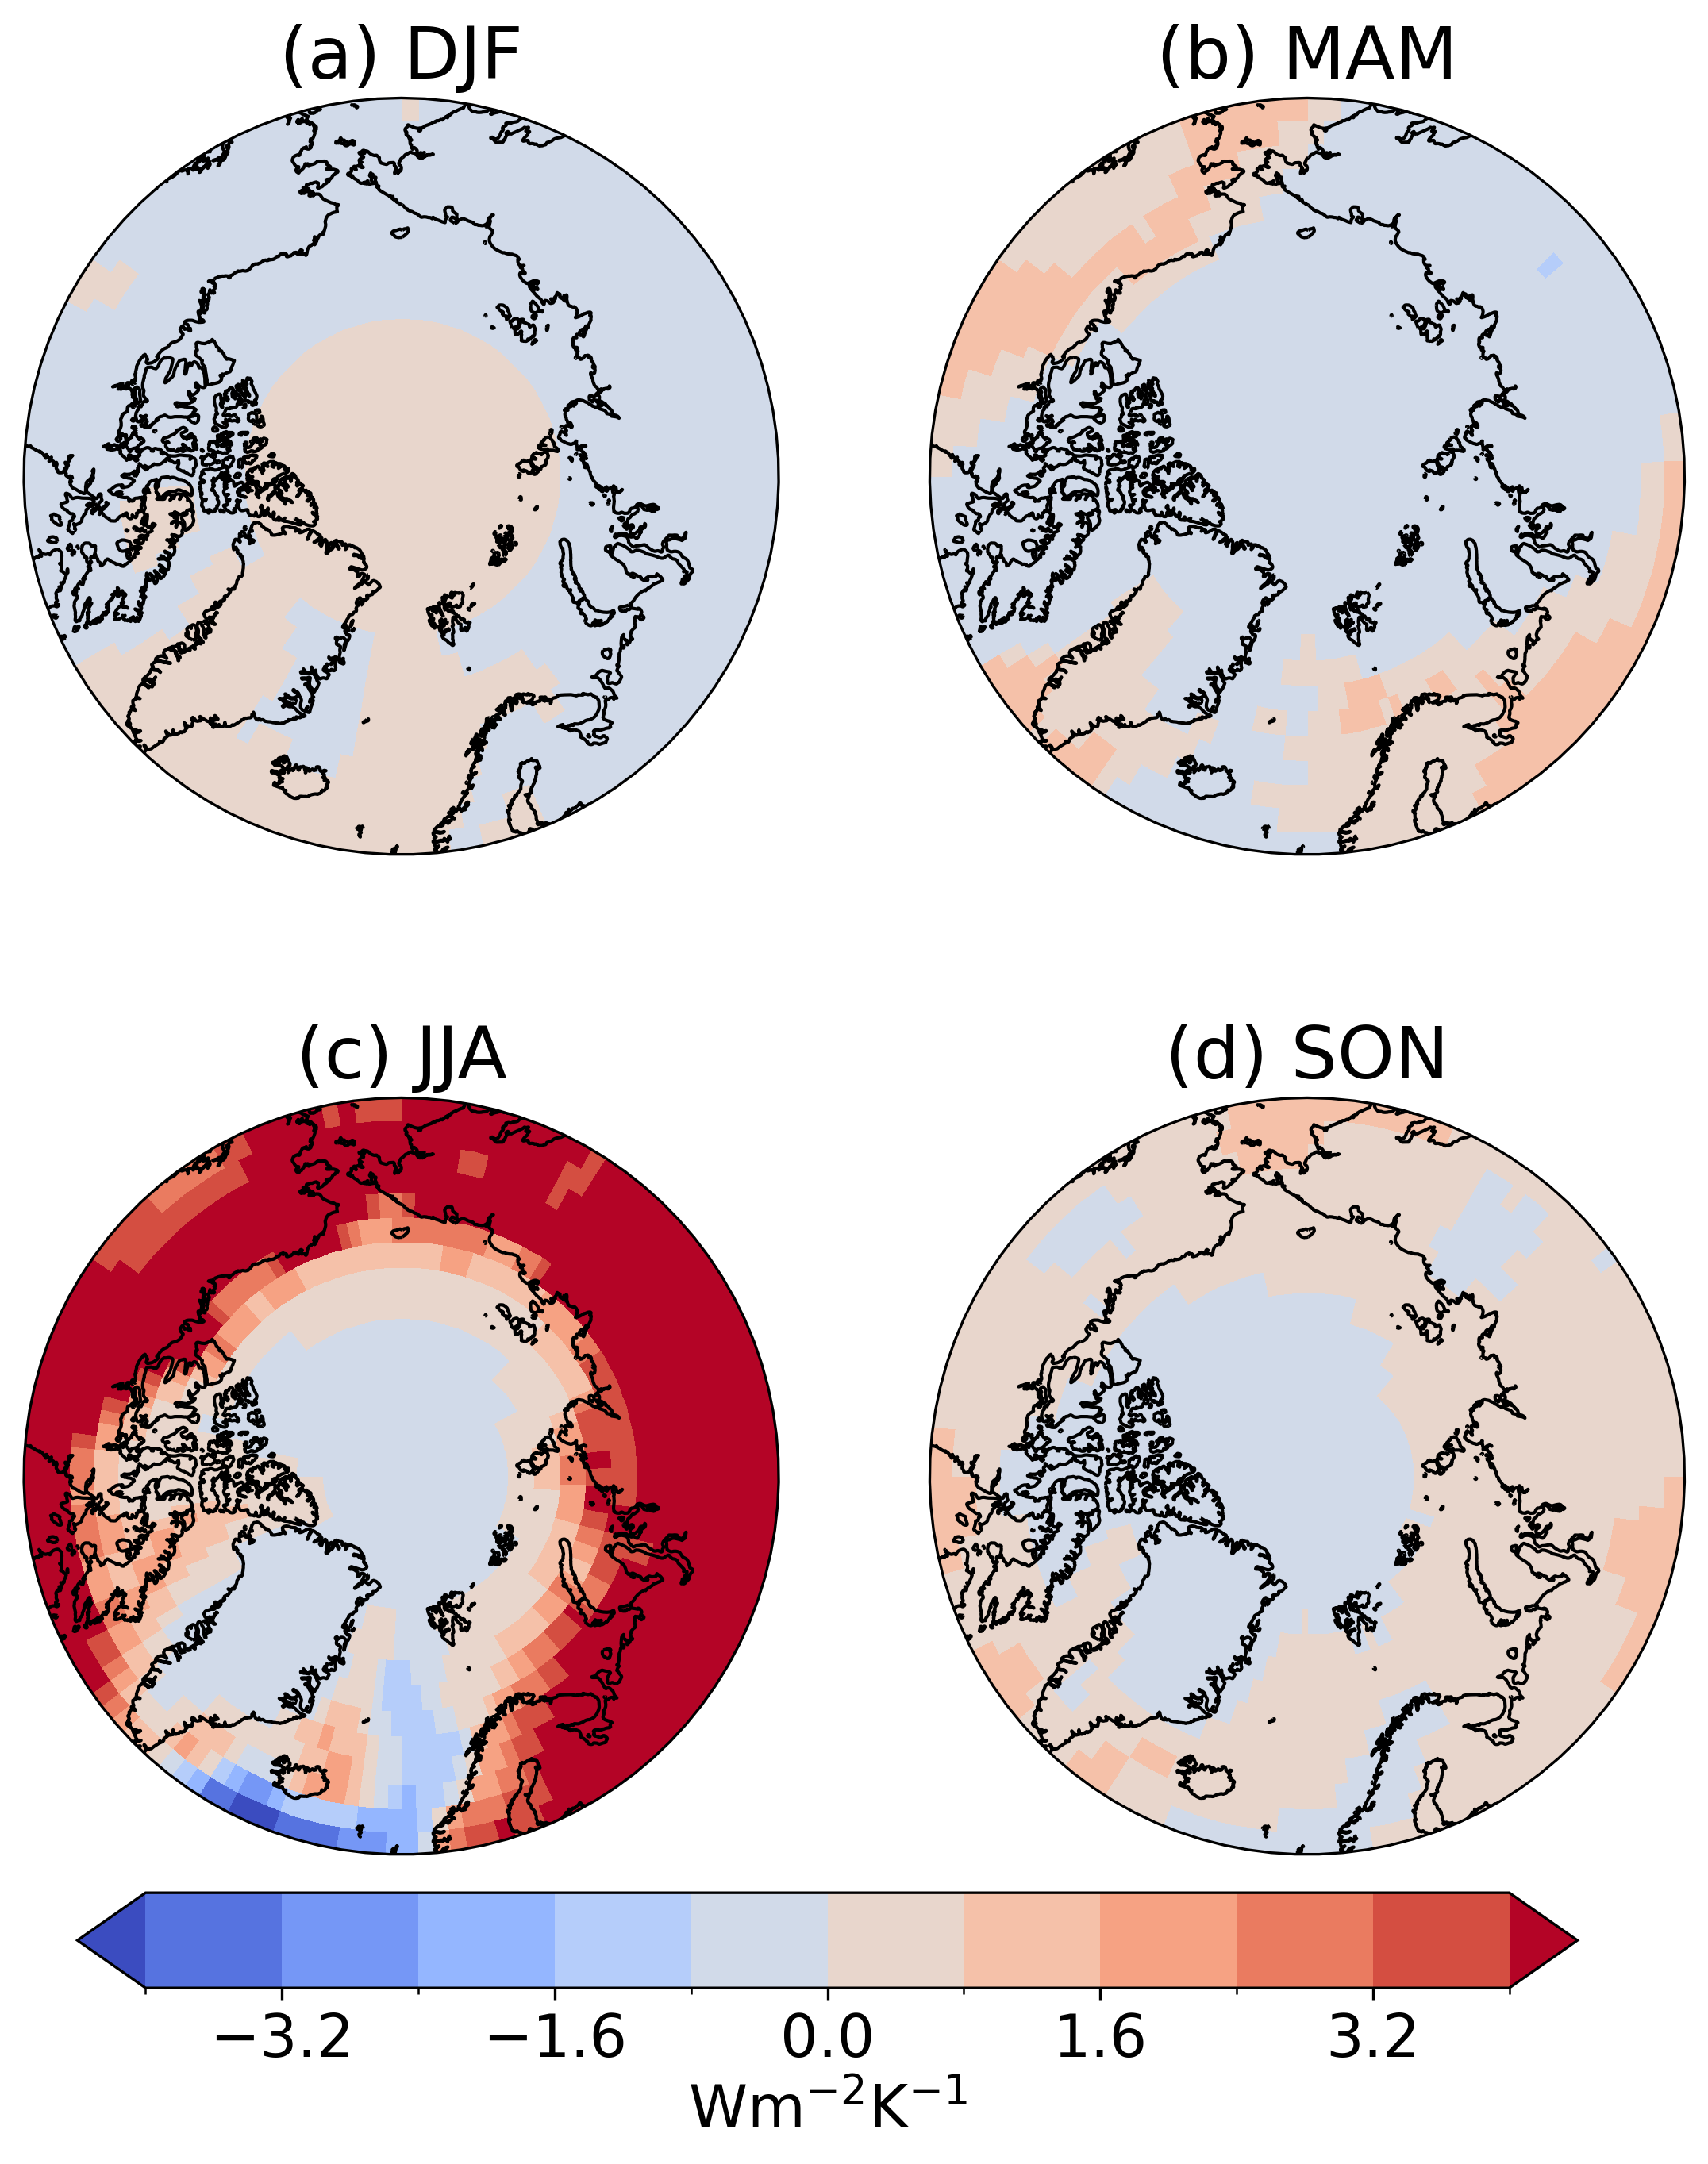

In [93]:
Arctic_limit = 60
ds_s = ds.groupby('time.season').mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit,90)))
var = 'SWcld_amt'
co2_conc = '4xCO2'
period=120
levels=np.linspace(-4, 4, 11)

import cartopy.crs as ccrs
fig = plt.figure(1, figsize=[9,10],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(2, 2, 1, projection=ccrs.Orthographic(0, 90))
ax2 = plt.subplot(2, 2, 2, projection=ccrs.Orthographic(0, 90))
ax3 = plt.subplot(2, 2, 3, projection=ccrs.Orthographic(0, 90))
ax4 = plt.subplot(2, 2, 4, projection=ccrs.Orthographic(0, 90))
#plt.subplots_adjust(top=0.85)

for ax,season,label in zip([ax1, ax2, ax3, ax4], ["DJF", "MAM","JJA","SON"], ["(a)", "(b)", "(c)", "(d)"]):
    
    functions.polarCentral_set_latlim([60,90], ax)
    data = ds_s[var].sel(season=season, period=period, co2_conc=co2_conc)
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='coolwarm', levels=levels,
                                        add_colorbar=False)
    ax.set_title(label+" "+season, fontsize=22)
    ax.coastlines()


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel("Wm$^{-2}$K$^{-1}$", fontsize=18)

#plt.savefig(wpath+"pdf/"+var+"_"+case1+"_"+case2+"eqbar.pdf", bbox_inches='tight')
#plt.savefig(wpath+"png/"+var+"_"+case1+"_"+case2+"eqbar.png", bbox_inches='tight')
#plt.savefig(wpath+"pdf/"+var+"_"+case1+"_"+case2+".pdf", bbox_inches='tight')
#plt.savefig(wpath+"png/"+var+"_"+case1+"_"+case2+".png", bbox_inches='tight')

#plt.clf()

Text(0.5, 0, 'SW Cloud Amount feedback \n Wm$^{-2}$K$^{-1}$')

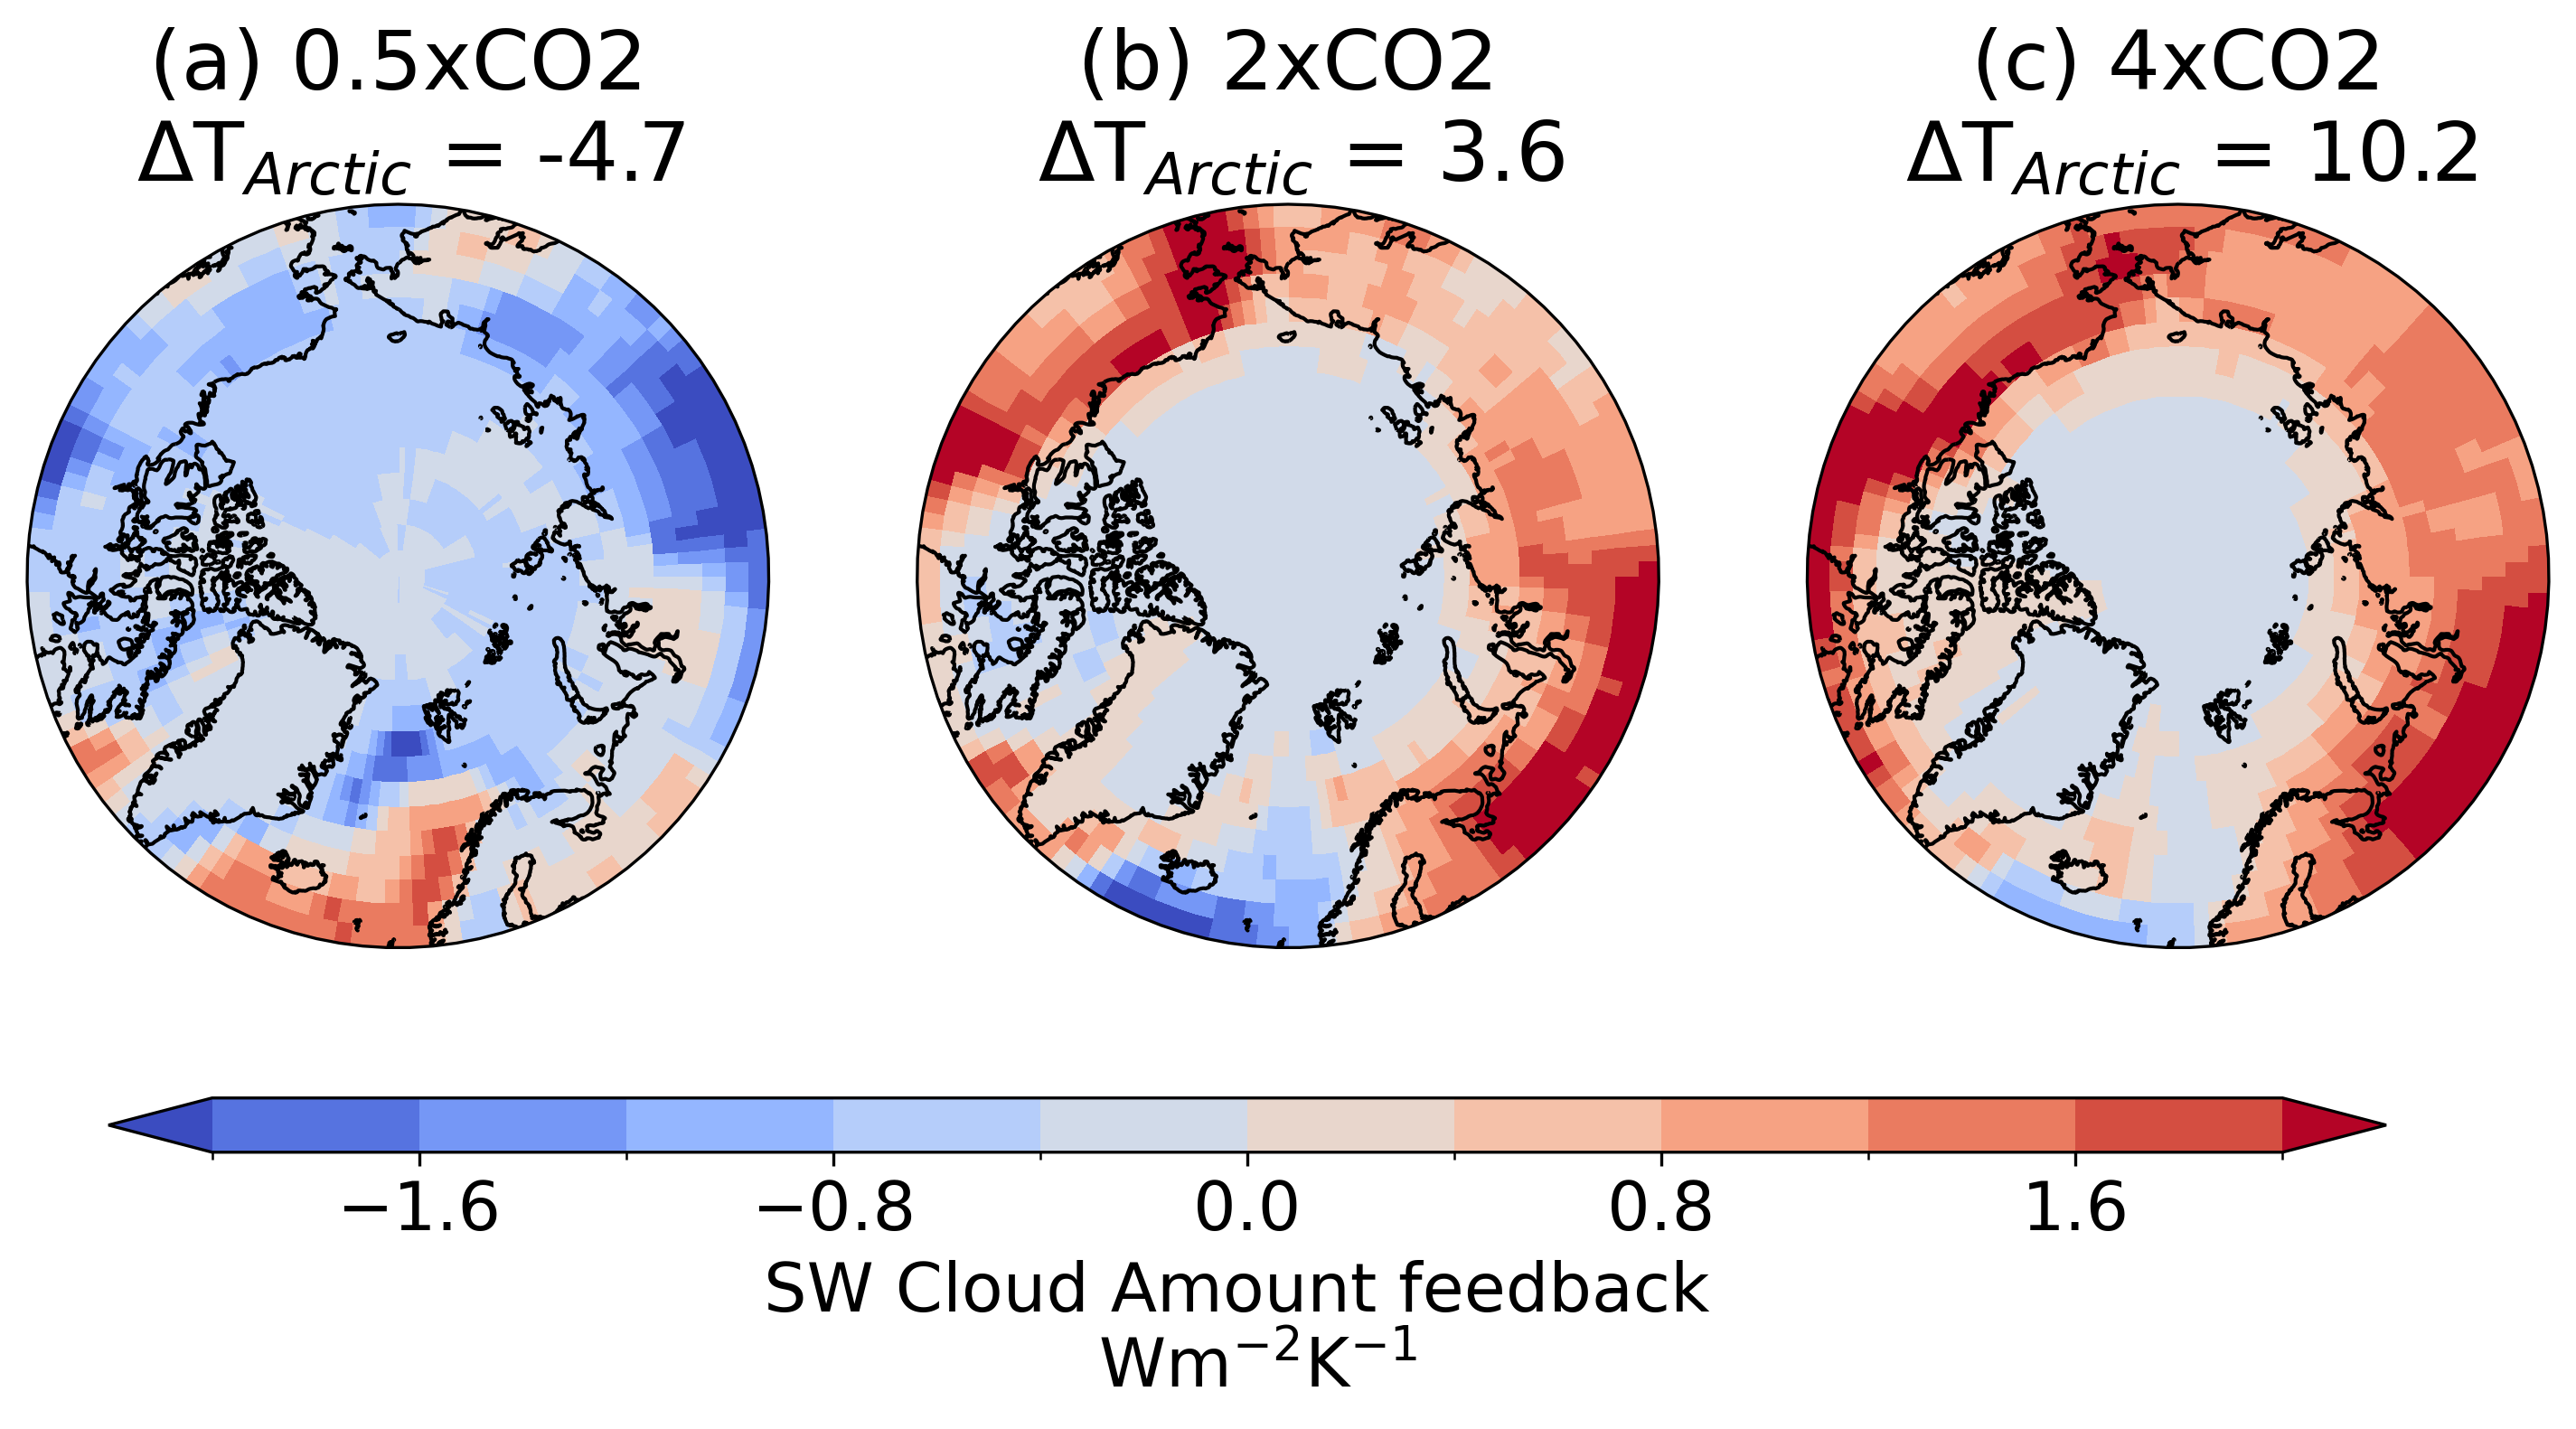

In [19]:
Arctic_limit = 60
ds_mean = ds.mean('time')
ds_dT_Arctic = functions.computeWeightedMean(ds_dT.sel(lat=slice(Arctic_limit,90)))
var = 'SWcld_amt'
period = 120
levels=np.linspace(-2, 2, 11)

import cartopy.crs as ccrs
fig = plt.figure(1, figsize=[12, 5],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(1, 3, 1, projection=ccrs.Orthographic(0, 90))
ax2 = plt.subplot(1, 3, 2, projection=ccrs.Orthographic(0, 90))
ax3 = plt.subplot(1, 3, 3, projection=ccrs.Orthographic(0, 90))
#plt.subplots_adjust(top=0.85)

for ax,co2_conc,label in zip([ax1, ax2, ax3], ['0.5xCO2', '2xCO2', '4xCO2'], ["(a)", "(b)", "(c)"]):
    
    functions.polarCentral_set_latlim([60,90], ax)
    data = ds_mean[var].sel(period=period, co2_conc=co2_conc)
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='coolwarm', levels=levels,
                                        add_colorbar=False)
    deltaT = np.round(ds_dT_Arctic['tas'].sel(period=period, co2_conc=co2_conc).mean('time').values, 1)
    ax.set_title(label+" "+co2_conc+'\n $\Delta$T$_{Arctic}$ = '+str(deltaT), fontsize=22)
    ax.coastlines()


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel("SW Cloud Amount feedback \n Wm$^{-2}$K$^{-1}$", fontsize=18)

/tmp/ipykernel_1928140/21533257.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


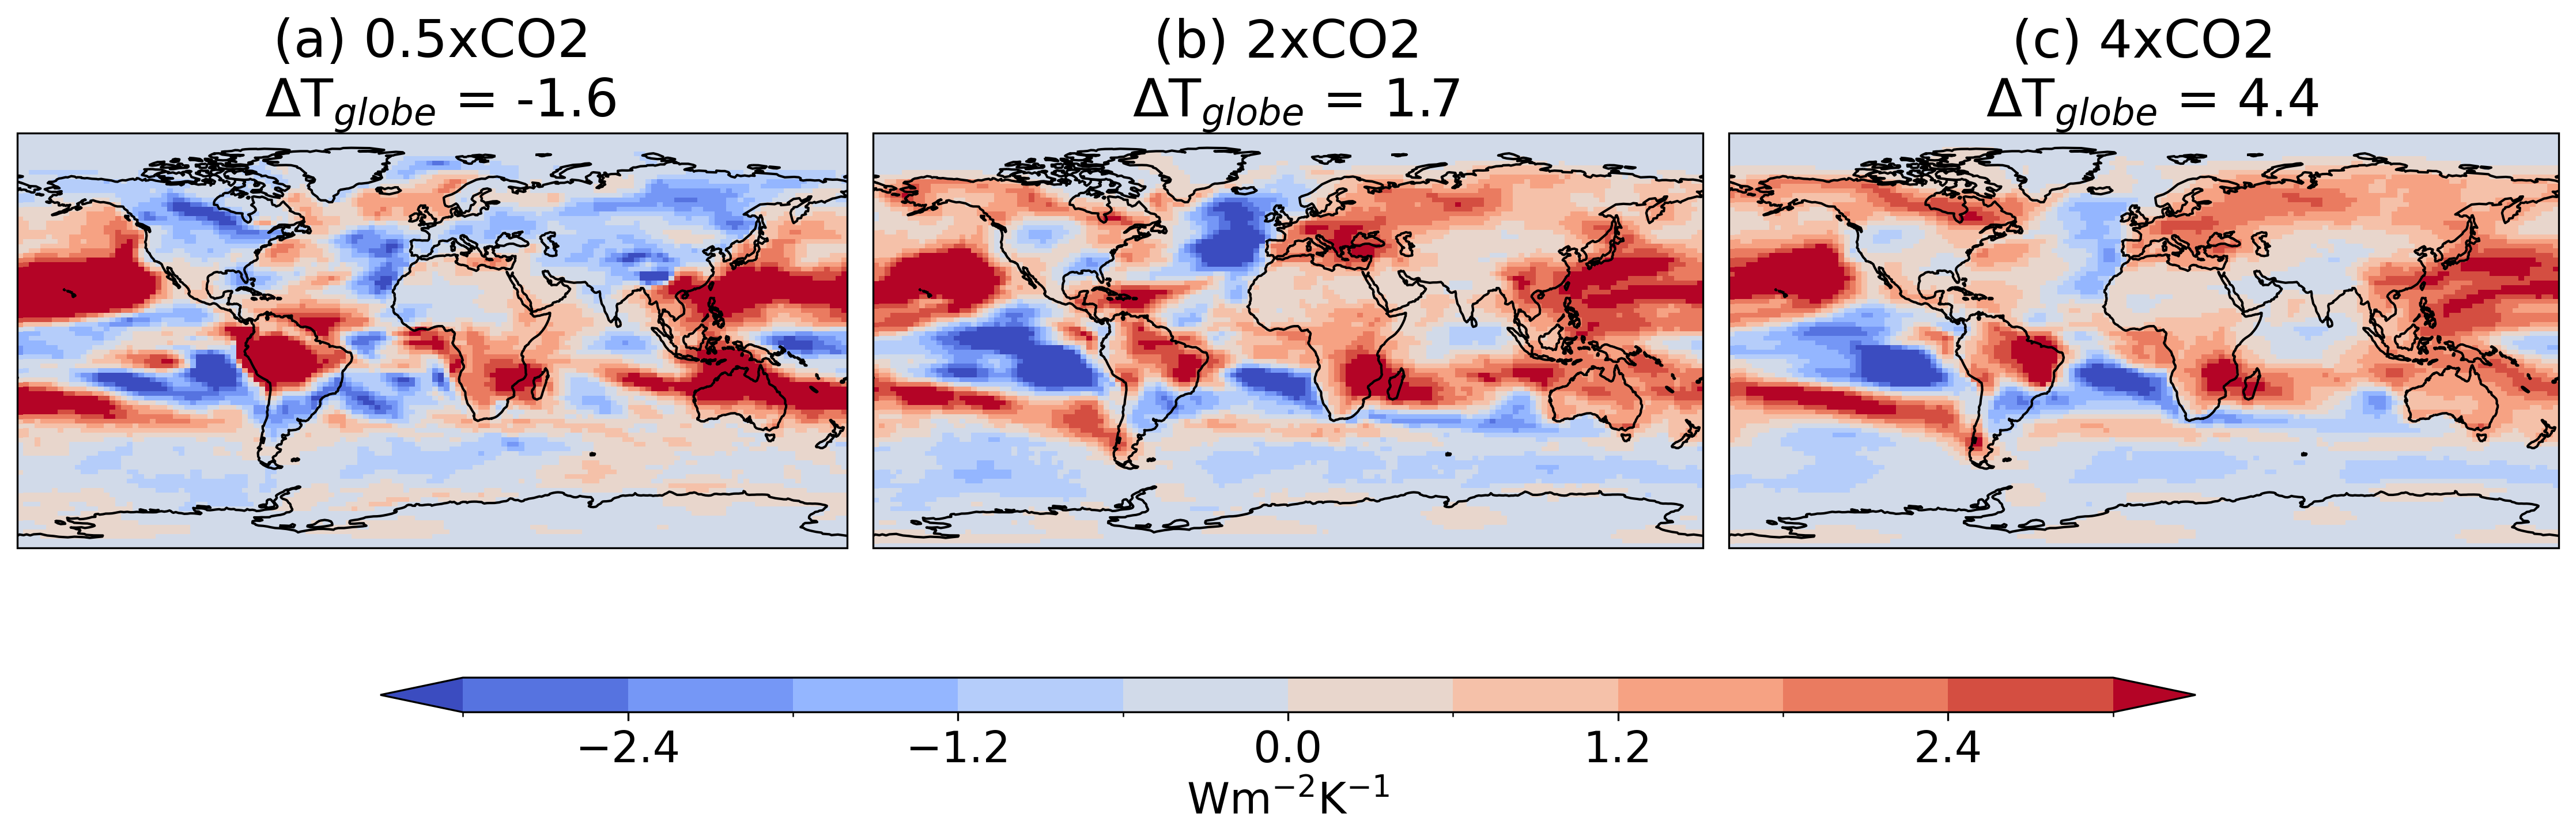

In [10]:
ds_mean = ds.mean('time')
ds_dT_globe = functions.computeWeightedMean(ds_dT)
var = 'SWcld_amt'
period = 120
lim = 3
levels=np.linspace(-lim, lim, 11)

import cartopy.crs as ccrs
fig = plt.figure(1, figsize=[15, 5],dpi=300)

# Set the projection to use for plotting
ax1 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax2 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax3 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
#plt.subplots_adjust(top=0.85)

for ax,co2_conc,label in zip([ax1, ax2, ax3], ['0.5xCO2', '2xCO2', '4xCO2'], ["(a)", "(b)", "(c)"]):
    
    ax.set_global()
    data = ds_mean[var].sel(period=period, co2_conc=co2_conc)
    map = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                        cmap='coolwarm', levels=levels,
                                        add_colorbar=False)
    ax.coastlines(transform=ccrs.PlateCarree())
    deltaT = np.round(ds_dT_globe['tas'].sel(period=period, co2_conc=co2_conc).mean('time').values, 1)
    ax.set_title(label+" "+co2_conc+'\n $\Delta$T$_{globe}$ = '+str(deltaT), fontsize=22)


cb_ax = fig.add_axes([0.15, 0.07, 0.7, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, spacing = 'uniform', extend='both', orientation='horizontal', fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel("Wm$^{-2}$K$^{-1}$", fontsize=18)
fig.tight_layout()